# Air Quality Prediction Experiment

This notebook combines PWWB, AirNow, and HRRR datasets for air quality prediction using TF-Keras.
Changes:
- A lot of hard coding things like sensor names
- Have another script handle ALL preprocessing; we just load the numpy files and stack them here
- Removed scaled target data for simplicity
- This experiment was done without loading all the training data, and instead uses a sequence. Look at the notebook without HRRR training to see how to load the training data fully into memory if you don't want to use this method.

Differences from original test:
- See: https://docs.google.com/document/d/1rGPPweWByw6mtkqNHEqw_7rtrZgMNuCtCK5q5NyviqE/edit?usp=sharing
- https://docs.google.com/document/d/1vY110YvxHQjSZJ7ZoMVVuU87FWh_J3S-ea9M1P6C47s/edit?usp=sharing

# Load data

In [1]:
# ========== EXPERIMENT CONFIGURATION ==========
# Change these variables to configure your experiment
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

EXPERIMENT_NAME = "January 2022 to December 2024"
EXPERIMENT_DESCRIPTION = "January 2025 fire period with PWWB, Airnow, and HRRR data."
EXPERIMENT_ID = "two_years_pwwb_airnow_hrrr"

# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"
TRAIN_SPLIT = 0.70
TEST_SPLIT = 0.15
VALID_SPLIT = 0.15

# Model parameters
EPOCHS = 100
BATCH_SIZE = 16
WEIGHT_DECAY = 0.01
LEARNING_RATE = 0.0001

all_channel_names = ['MAIAC_AOD', 'TROPOMI_NO2', 'METAR_Wind_U', 'METAR_Wind_V', 'AirNow_PM25', 'HRRR_COLMD']

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Description: {EXPERIMENT_DESCRIPTION}")
print(f"Date Range: {START_DATE} to {END_DATE}")
print(f"Train/Test Split: {TRAIN_SPLIT*100:.0f}%/{(1-TRAIN_SPLIT)*100:.0f}% (temporal)")

Experiment: January 2022 to December 2024
Description: January 2025 fire period with PWWB, Airnow, and HRRR data.
Date Range: 2022-12-01-00 to 2024-12-01-00
Train/Test Split: 70%/30% (temporal)


In [2]:
# load train test and valid files
print("Loading testing, training, and validation files...")

test_files = ["MAIAC_AOD_X_test.npy", "TROPOMI_NO2_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy", "AirNow_PM25_X_test.npy", "HRRR_COLMD_X_test.npy"]
train_files = ["MAIAC_AOD_X_train.npy", "TROPOMI_NO2_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy", "AirNow_PM25_X_train.npy", "HRRR_COLMD_X_train.npy"]
valid_files = ["MAIAC_AOD_X_valid.npy", "TROPOMI_NO2_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy", "AirNow_PM25_X_valid.npy", "HRRR_COLMD_X_valid.npy"]

data_size = [
    os.path.getsize(f"final_input_data/{file}") 
    for file in test_files + valid_files
]
print(f"Total size of data that will be loaded in RAM: {sum(data_size) * 1e-9:.2f}GB\n")

print("Loading numpy arrays...")
X_test_scaled = np.stack([np.load(f"final_input_data/{file}") for file in test_files], axis=-1)
X_valid_scaled = np.stack([np.load(f"final_input_data/{file}") for file in valid_files], axis=-1)

Y_test = np.load("final_input_data/Y_test.npy")
Y_valid = np.load("final_input_data/Y_valid.npy")
print("Data successfully loaded.")

Loading testing, training, and validation files...
Total size of data that will be loaded in RAM: 2.02GB

Loading numpy arrays...
Data successfully loaded.


In [3]:
# Debug cell to check channel names and data shapes
print("=== DEBUGGING CHANNEL INFORMATION ===")
print(f"Experiment name: {EXPERIMENT_NAME}")
print(f"X_train_scaled shape: {X_test_scaled.shape}")
print(f"Number of channels in data: {X_test_scaled.shape[4]}")
print(f"Number of channel names provided: {len(all_channel_names)}")
print(f"Channel names length matches data channels: {len(all_channel_names) == X_test_scaled.shape[4]}")
print()

print("Channel names provided:")
for i, name in enumerate(all_channel_names):
    print(f"  {i}: {name}")
print()

print("What the visualization function will use:")
n_channels = X_test_scaled.shape[4]
if all_channel_names is None or len(all_channel_names) != n_channels:
    effective_channel_names = [f"Channel {i}" for i in range(n_channels)]
    print("  Using GENERIC channel names (this is the problem!):")
else:
    effective_channel_names = all_channel_names
    print("  Using PROVIDED channel names:")

for i, name in enumerate(effective_channel_names):
    print(f"  {i}: {name}")
print()

print("=== DATA SAMPLE CHECK ===")
# Check what's actually in the first few channels
sample_idx = 42  # Use same sample as visualization
for c in range(min(3, n_channels)):  # Check first 3 channels
    data = X_test_scaled[sample_idx, 0, :, :, c]  # First frame
    print(f"Channel {c} ({effective_channel_names[c] if c < len(effective_channel_names) else 'Unknown'}):")
    print(f"  Min: {data.min():.6f}, Max: {data.max():.6f}, Mean: {data.mean():.6f}")
    print()

=== DEBUGGING CHANNEL INFORMATION ===
Experiment name: January 2022 to December 2024
X_train_scaled shape: (2631, 5, 40, 40, 6)
Number of channels in data: 6
Number of channel names provided: 6
Channel names length matches data channels: True

Channel names provided:
  0: MAIAC_AOD
  1: TROPOMI_NO2
  2: METAR_Wind_U
  3: METAR_Wind_V
  4: AirNow_PM25
  5: HRRR_COLMD

What the visualization function will use:
  Using PROVIDED channel names:
  0: MAIAC_AOD
  1: TROPOMI_NO2
  2: METAR_Wind_U
  3: METAR_Wind_V
  4: AirNow_PM25
  5: HRRR_COLMD

=== DATA SAMPLE CHECK ===
Channel 0 (MAIAC_AOD):
  Min: -1.048153, Max: 1.898079, Mean: 0.314288

Channel 1 (TROPOMI_NO2):
  Min: -0.909231, Max: 1.187532, Mean: -0.332034

Channel 2 (METAR_Wind_U):
  Min: -0.576410, Max: -0.281264, Mean: -0.413731



Visualizing data for January 2022 to December 2024...


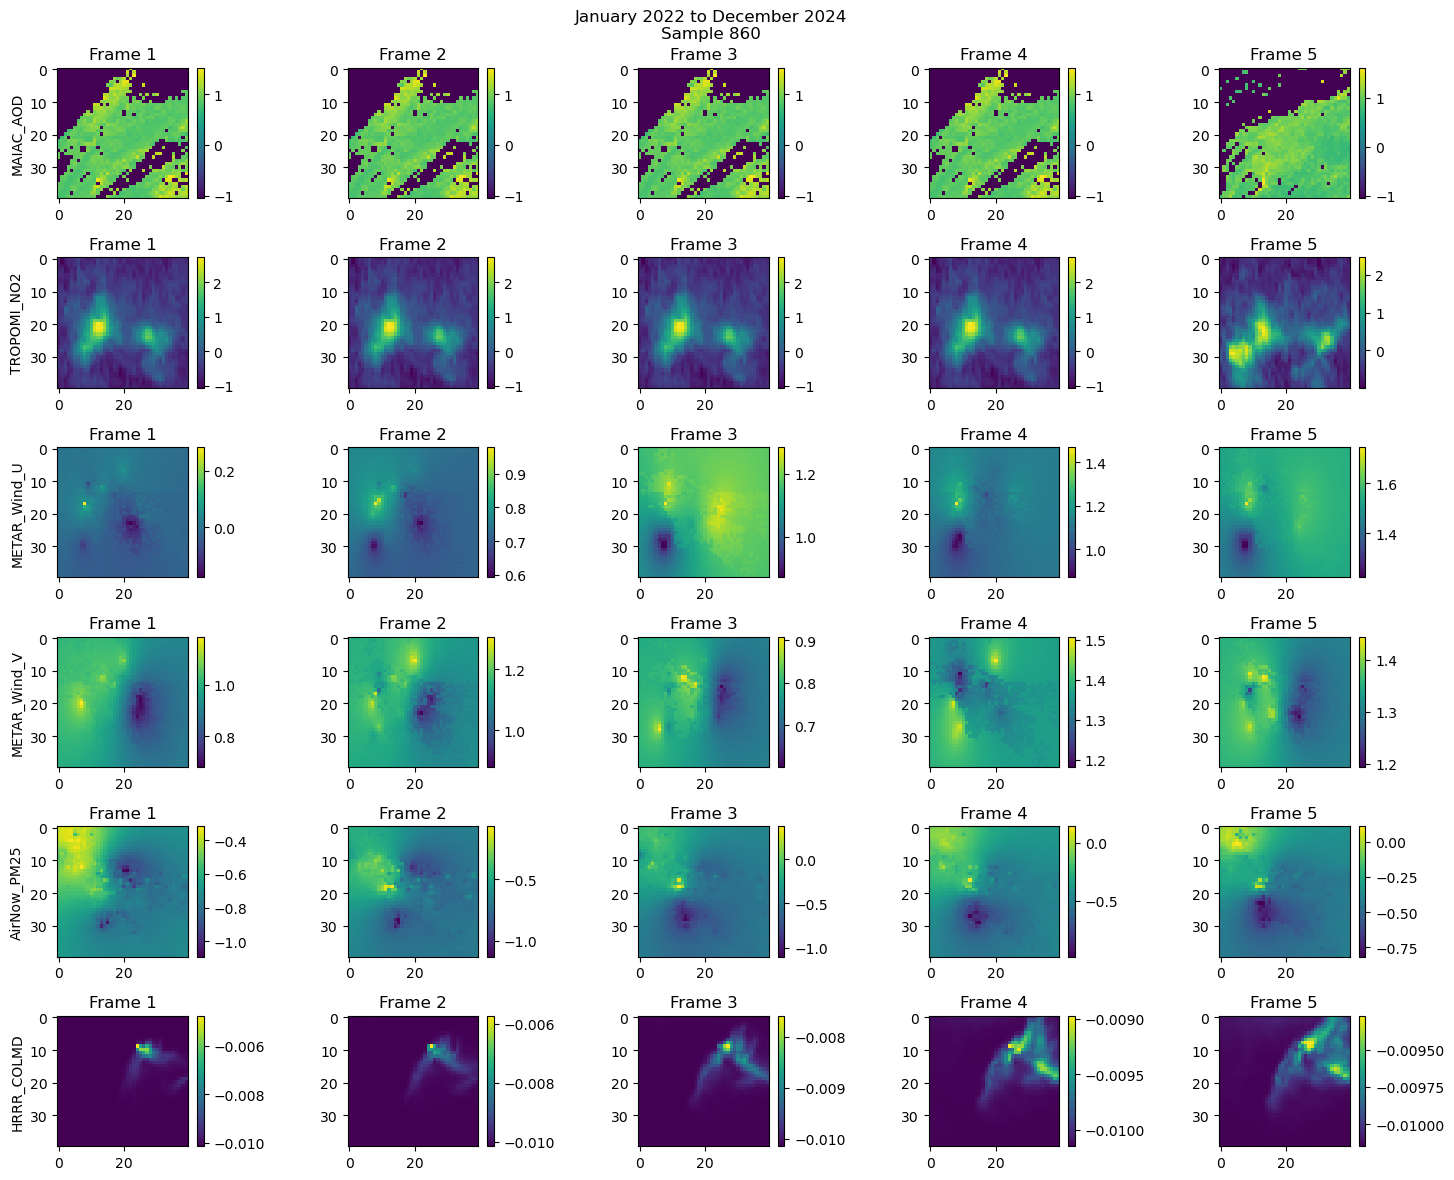

Target values: [[ 6.4  8.2 10.6  8.4  9.4  4.5  5.9  6.9]
 [ 5.2  8.6 10.2  8.4  7.7  4.2  9.4  8.5]
 [ 5.6  7.1 11.3  5.9  6.7  5.8  8.1  8.1]
 [ 5.8  6.2  9.8  4.1  8.8  6.1  7.1  6.2]
 [ 5.4  6.2  9.5  5.5  8.9  6.1  5.9  5.3]]


In [4]:
# Function to visualize data from experiment
np.random.seed(42)
def visualize_experiment_data(X, Y, channel_names=None, sample_idx=None, experiment_name="Experiment"):
    """Visualize data from the experiment"""
    # Get a random sample if none provided
    if sample_idx is None:
        sample_idx = np.random.choice(range(len(X)), size=1)[0]
    
    # Get channel information
    n_channels = X.shape[4]
    n_frames = X.shape[1]
    
    # Use provided channel names or create default ones
    if channel_names is None or len(channel_names) != n_channels:
        channel_names = [f"Channel {i}" for i in range(n_channels)]
    
    # Create figure
    fig, axes = plt.subplots(n_channels, n_frames, figsize=(3*n_frames, 2*n_channels))
    if n_channels == 1:
        axes = axes.reshape(1, -1)
    
    # Plot each channel and frame
    for c in range(n_channels):
        channel_name = channel_names[c] if c < len(channel_names) else f"Channel {c}"
        
        for f in range(n_frames):
            ax = axes[c, f]
            data = X[sample_idx, f, :, :, c]
            
            im = ax.imshow(data)
            
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            if f == 0:
                ax.set_ylabel(channel_name)
            ax.set_title(f"Frame {f+1}")
    
    # Set title
    plt.suptitle(f"{experiment_name}\nSample {sample_idx}")
    plt.tight_layout()
    plt.show()
    
    # Print target values
    if Y is not None:
        print(f"Target values: {Y[sample_idx]}")

# Run the visualization  
print(f"Visualizing data for {EXPERIMENT_NAME}...")
visualize_experiment_data(X_test_scaled, Y_test, channel_names=all_channel_names, experiment_name=EXPERIMENT_NAME)

# Model Definition

In [5]:
_, n_frames, output_size = Y_test.shape # (frames, stations)
input_shape = X_test_scaled.shape[1:] # (frames, height, width, channels)

print(
    f"X_test_scaled shape:  {X_test_scaled.shape}\n"
    f"Y_test shape:         {Y_test.shape}\n\n"

    f"X_valid_scaled shape: {X_valid_scaled.shape}\n"
    f"Y_valid shape:        {Y_valid.shape}\n\n"

    f"Input shape:          {input_shape}\n"
    f"Output shape:         ({n_frames}, {output_size})\n"
)

X_test_scaled shape:  (2631, 5, 40, 40, 6)
Y_test shape:         (2631, 5, 8)

X_valid_scaled shape: (2630, 5, 40, 40, 6)
Y_valid shape:        (2630, 5, 8)

Input shape:          (5, 40, 40, 6)
Output shape:         (5, 8)



In [6]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization, LayerNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape, GlobalAveragePooling2D
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=input_shape)
)

seq.add(
    ConvLSTM2D(
        filters=15, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True,
        dropout=0.6,
        recurrent_dropout=0.6,
        kernel_regularizer=keras.regularizers.l2(0.01)
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True,
        dropout=0.6,
        recurrent_dropout=0.6,
        kernel_regularizer=keras.regularizers.l2(0.01)
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

# applies layer to every temporal slice (first dimension)
# so for (5, 40, 40, 1), the layer is applied to each frame, a total of 5 times
seq.add(TimeDistributed(Flatten()))

seq.add(Dropout(rate=0.6))

seq.add(Dense(output_size, activation='relu'))

seq.compile(
    loss='mean_absolute_error', 
    optimizer=keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.01)
)
seq.summary()

2025-06-13 13:11:20.425593: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 13:11:20.488119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749845480.501717    8619 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749845480.506698    8619 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-13 13:11:20.567482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 1600)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 1600)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5, 8)           │        12,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,499 (333.98 KB)

 Trainable params: 85,499 (333.98 KB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [7]:
from keras.callbacks import EarlyStopping, TensorBoard
import os
import time

# tensorboard gradient logging callback
# at the end of an epoch, pass in a sample batch and calculate the gradients
class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, data_sample):
        super().__init__()
        self.writer = tf.summary.create_file_writer(log_dir)
        self.data_sample = data_sample  # A batch of (x, y) from your training data

    def on_epoch_end(self, epoch, logs=None):
        # log gradients
        x, y = self.data_sample

        with tf.GradientTape() as tape:
            loss = self.model.compute_loss(
                y=y, 
                y_pred=self.model(x, training=True)
            )

        gradients = tape.gradient(loss, self.model.trainable_weights)
        grad_norm = tf.linalg.global_norm(gradients)

        # plot gradients
        with self.writer.as_default():
            tf.summary.scalar("gradient_norm/global", grad_norm, step=epoch)
            
            for weight, grad in zip(self.model.trainable_weights, gradients):
                if grad is not None:
                    tf.summary.histogram(f"gradients/{weight.name}", grad, step=epoch)
            self.writer.flush()

# tensorboard callback setup
def get_run_logdir(
    root_logdir, 
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
):
    return os.path.join(root_logdir, run_id)
    
run_logdir = get_run_logdir(
    root_logdir=os.path.join(os.curdir, "my_logs"),
    run_id="hrrr_dropout_l2_weightdecay_lr"
)

# define list of callbacks we're gonna use
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20),
    TensorBoard(run_logdir, histogram_freq=1),
    GradientLogger(run_logdir, data_sample=(X_test_scaled[:32], Y_test[:32]))
]

In [8]:
import sys
sys.path.append("../..")
from libs.sequence import PWWBPyDataset
train_files = [f"final_input_data/{file}" for file in train_files]
generator = PWWBPyDataset(train_files, "final_input_data/Y_train.npy", BATCH_SIZE, workers=8, use_multiprocessing=True) 

In [9]:
history = seq.fit(
    generator,
    epochs=EPOCHS,
    validation_data=(X_valid_scaled, Y_valid),
    callbacks=callbacks
)

print(f"\n✓ Model training completed for {EXPERIMENT_NAME}!")

Epoch 1/2


I0000 00:00:1749845486.344301    8706 service.cc:148] XLA service 0x78bb400ef600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749845486.344336    8706 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-06-13 13:11:26.461613: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749845486.855820    8706 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-06-13 13:11:28.056220: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[16,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backen

137/768 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 8.6124

2025-06-13 13:11:40.051496: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[2,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[2,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-13 13:11:40.238545: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[2,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,6,40,40]{3,2,1,0}, f32[15,6,3,3]{3,2,1,0}, f32[15]{0}, f32[2,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.9879

2025-06-13 13:12:06.478685: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,6,40,40]{3,2,1,0}, f32[15,6,3,3]{3,2,1,0}, f32[15]{0}, f32[32,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-13 13:12:06.537181: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[32,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

768/768 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - loss: 5.9863 - val_loss: 4.6546
Epoch 2/2
768/768 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - loss: 3.8192 - val_loss: 4.7877

✓ Model training completed for January 2022 to December 2024!


# Model Evaluation


Evaluating model for January 2022 to December 2024...


2025-06-13 13:12:41.861852: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,6,40,40]{3,2,1,0}, f32[15,6,3,3]{3,2,1,0}, f32[15]{0}, f32[7,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-13 13:12:41.911615: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[7,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

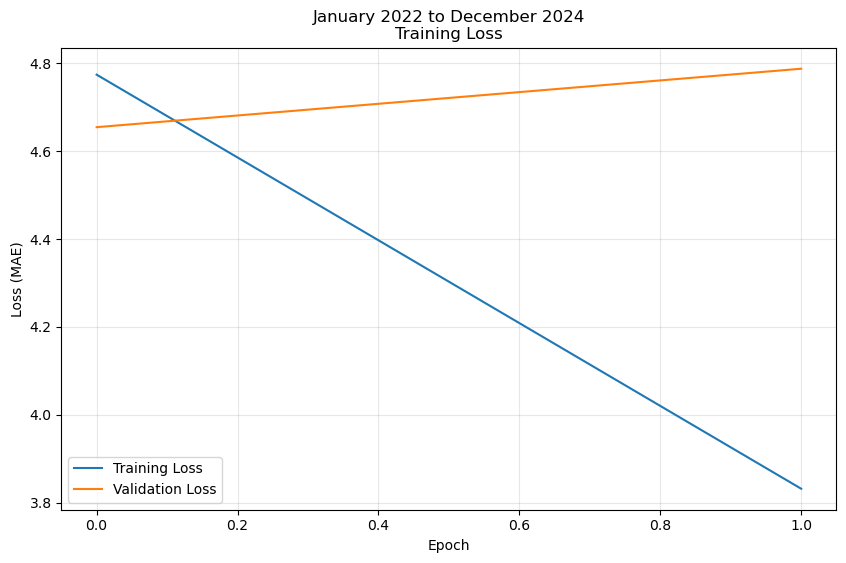


✓ Evaluation completed for January 2022 to December 2024
Results saved to: experiment_output/two_years_pwwb_airnow_hrrr/results


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# Create output directory for results
output_dir = f"experiment_output/{EXPERIMENT_ID}"
os.makedirs(output_dir, exist_ok=True)

# Evaluate model
print(f"\nEvaluating model for {EXPERIMENT_NAME}...")
y_pred = seq.predict(X_test_scaled, verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'{EXPERIMENT_NAME}\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

# Save results (save both scaled and real versions)
results_dir = os.path.join(output_dir, "results")
os.makedirs(results_dir, exist_ok=True)

# Save real scale results for analysis
np.save(os.path.join(results_dir, "y_pred.npy"), y_pred)
np.save(os.path.join(results_dir, "Y_test.npy"), Y_test)

# Save model and scaler
seq.save(os.path.join(results_dir, "model.keras"))

print(f"\n✓ Evaluation completed for {EXPERIMENT_NAME}")
print(f"Results saved to: {results_dir}")

# Detailed Analysis


Sensors in January 2022 to December 2024: ['Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 'Los Angeles - N. Main Street', 'Compton', 'Long Beach Signal Hill', 'Glendora - Laurel']

=== FRAME-BASED PREDICTION ANALYSIS ===
Analyzing 5 future frames (hours) for 8 sensors
🎯 COMPREHENSIVE CONVLSTM PERFORMANCE ANALYSIS
📊 Analyzing 5 frames (hours) across 8 sensors
📈 Dataset: 2631 samples

This analysis evaluates ConvLSTM's ability to predict air quality across multiple future time frames
and spatial locations, revealing critical spatio-temporal prediction patterns.

📊 1. FRAME-BY-FRAME RMSE
────────────────────────────────────────────────────────────
📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



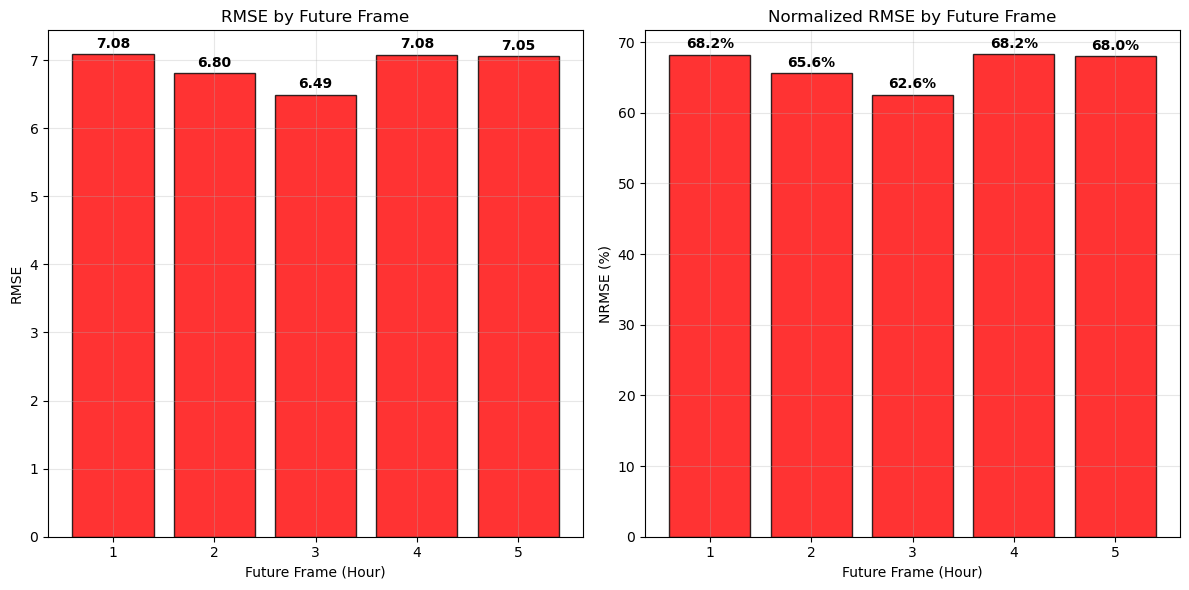


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 7.083 (68.2%)
Hour 2: RMSE = 6.804 (65.6%)
Hour 3: RMSE = 6.492 (62.6%)
Hour 4: RMSE = 7.079 (68.2%)
Hour 5: RMSE = 7.053 (68.0%)

📍 2. AVERAGE RMSE PER STATION (ALL HOURS)
───────────────────────────────────────────────────────
📍 SPATIAL PERFORMANCE ANALYSIS
This identifies which monitoring stations are consistently difficult for ConvLSTM to predict.
Challenging stations often have complex local meteorology or unique pollution sources.



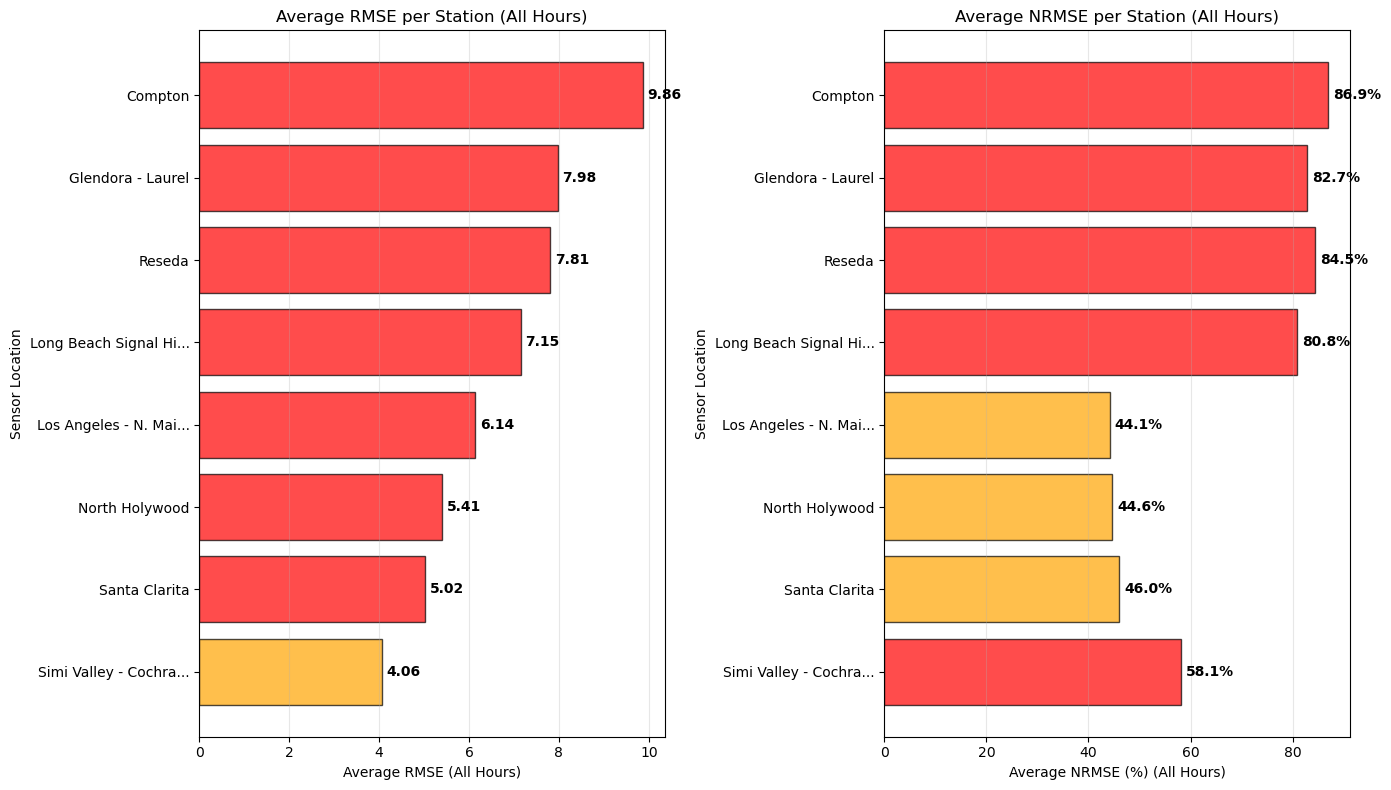


📍 STATION PERFORMANCE SUMMARY (All Hours Combined)

🟢 EXCELLENT Stations (RMSE < 1.5): 0

🟡 GOOD Stations (1.5-3.0): 0

🟠 FAIR Stations (3.0-5.0): 1
   • Simi Valley - Cochran Street: 4.063

🔴 POOR Stations (≥ 5.0): 7
   • Santa Clarita: 5.020
   • North Holywood: 5.407
   • Los Angeles - N. Main Street: 6.138
   • Long Beach Signal Hill: 7.151
   • Reseda: 7.806
   • Glendora - Laurel: 7.975
   • Compton: 9.861

📊 SUMMARY STATISTICS:
   🏆 Best Station:  Simi Valley - Cochran Street (RMSE: 4.063)
   💥 Worst Station: Compton (RMSE: 9.861)
   📈 Average RMSE:  6.678
   📏 RMSE Range:    5.798
   🎯 Reliability:   0/8 stations ≤ 3.0 RMSE

📊 SUMMARY TABLE - RMSE BY HOUR AND SENSOR
Sensor                   │ Hour 1 │ Hour 2 │ Hour 3 │ Hour 4 │ Hour 5 │  Avg   
─────────────────────────┼────────┼────────┼────────┼────────┼────────┼────────
Simi Valley - Cochran St │  4.34  │  4.09  │  3.84  │  4.10  │  3.91  │  4.06  
Reseda                   │  8.50  │  7.91  │  7.07  │  7.81  │  7.68  │  7.7

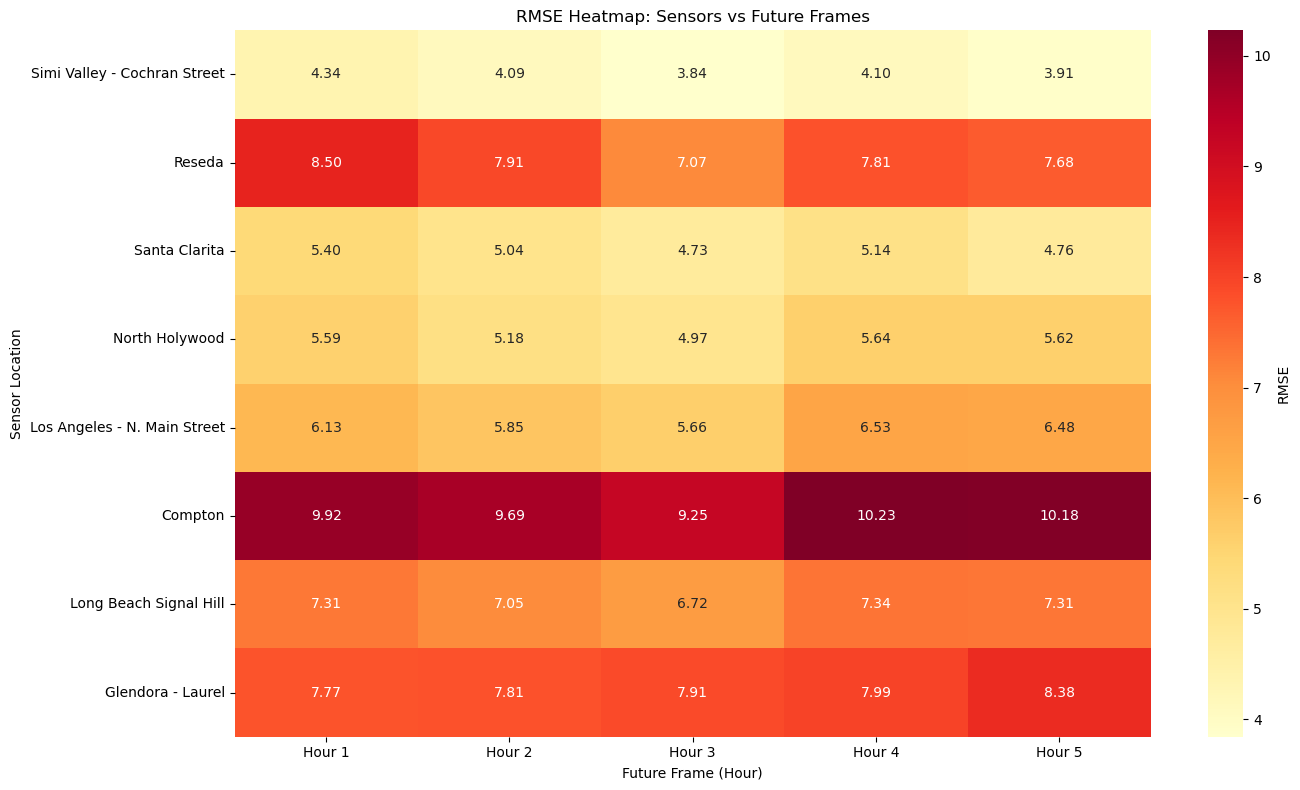


🔥 WORST PERFORMING COMBINATIONS:
Compton at Hour 4: RMSE = 10.231
Compton at Hour 5: RMSE = 10.184
Compton at Hour 1: RMSE = 9.919
Compton at Hour 2: RMSE = 9.688
Compton at Hour 3: RMSE = 9.251

📈 4. TIME SERIES BY FRAME
───────────────────────────────────
Temporal pattern analysis

🕐 Hour 1 Time Series


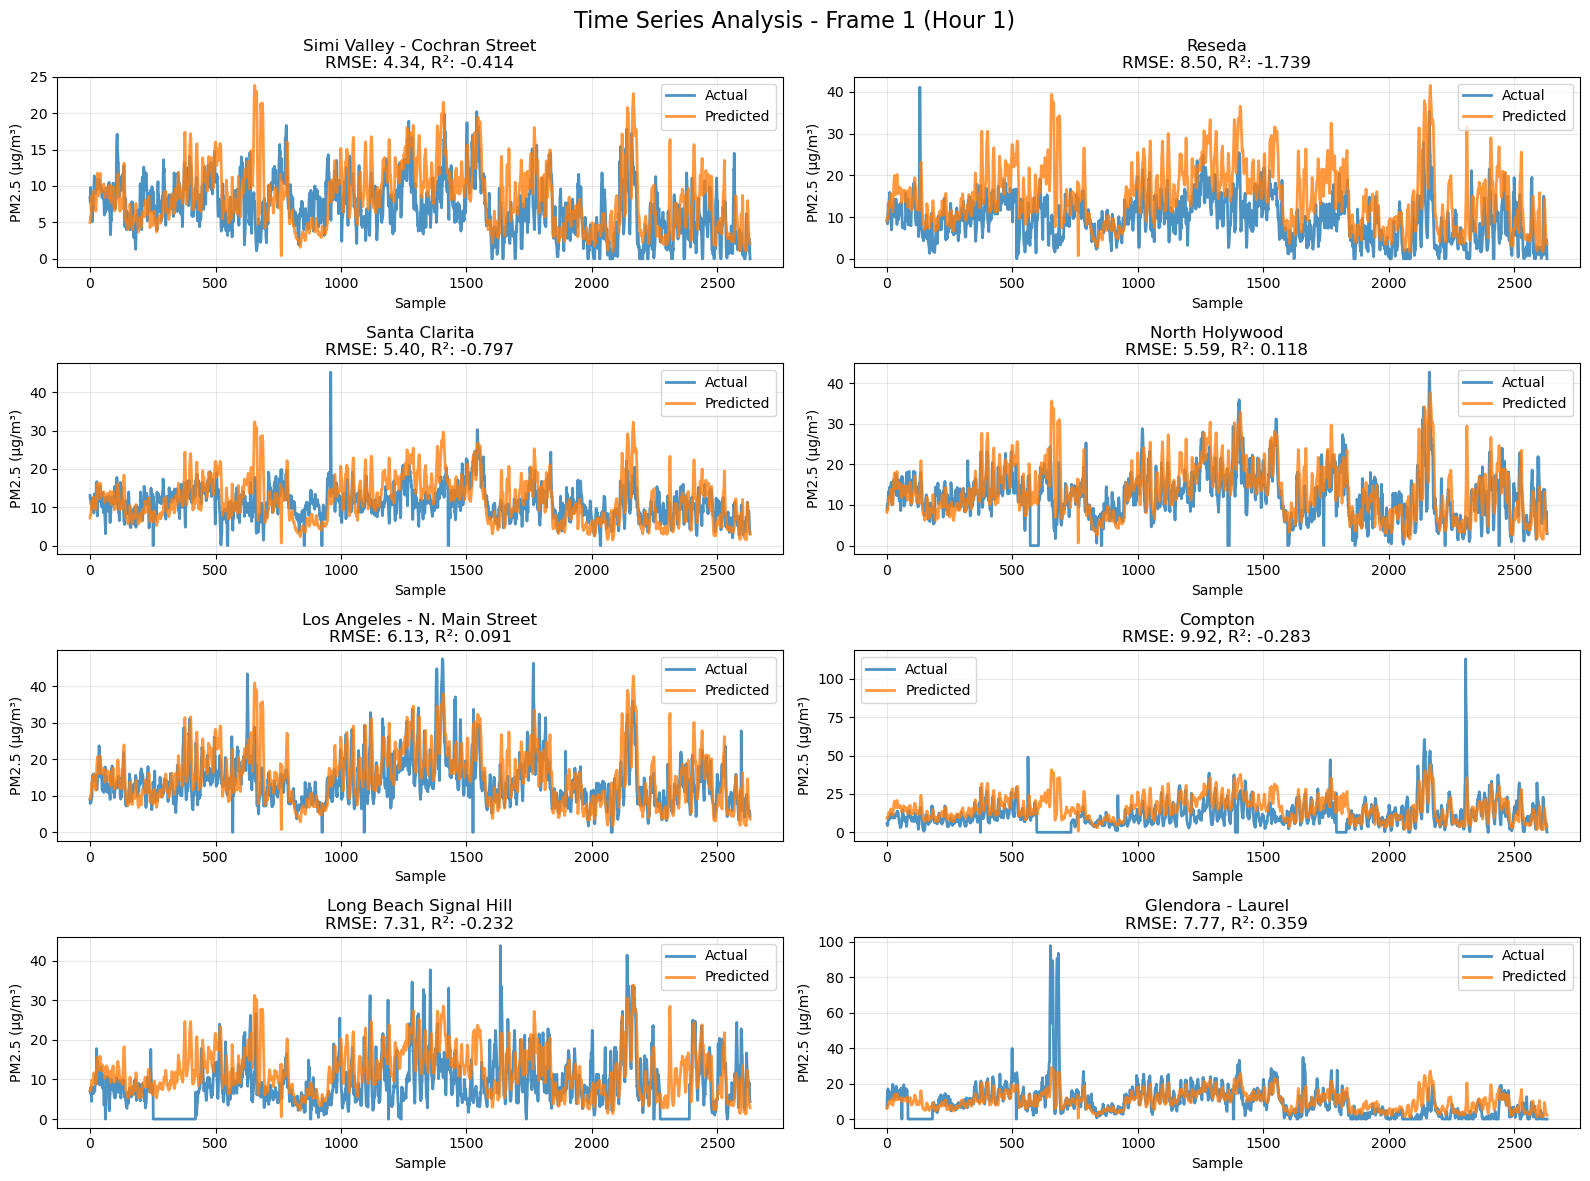


🕐 Hour 2 Time Series


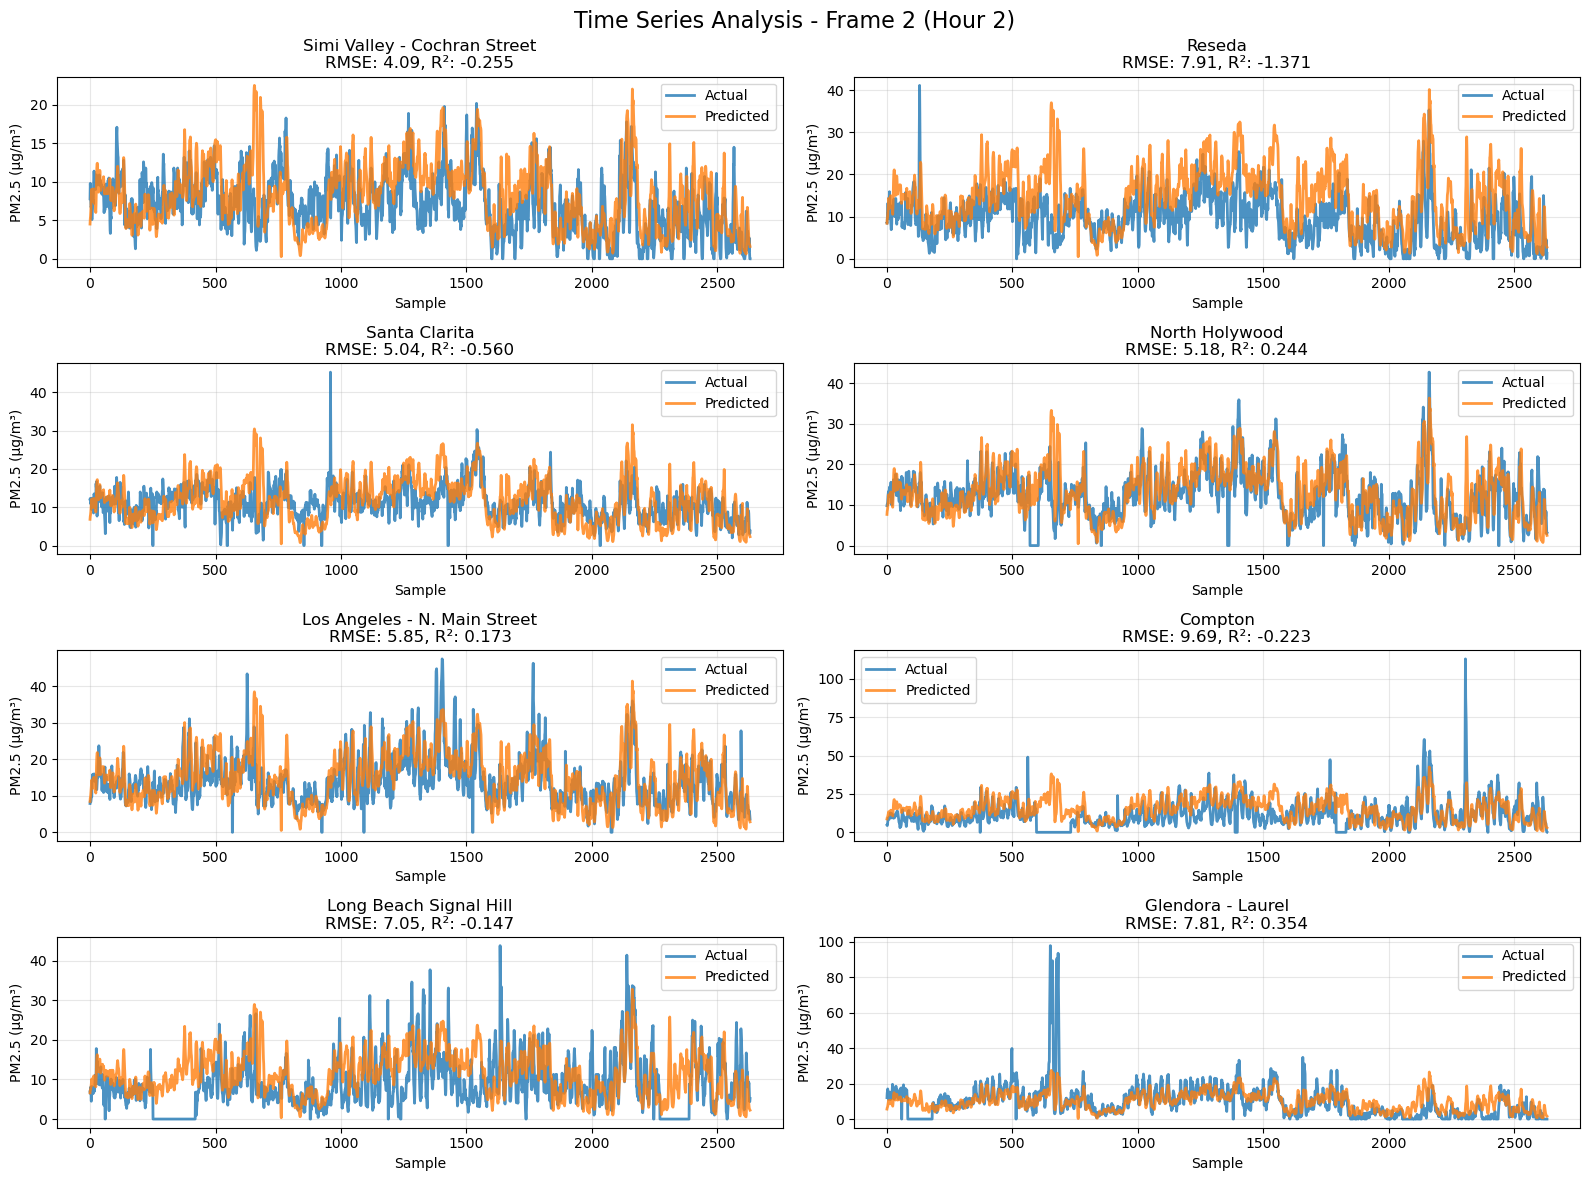


🕐 Hour 3 Time Series


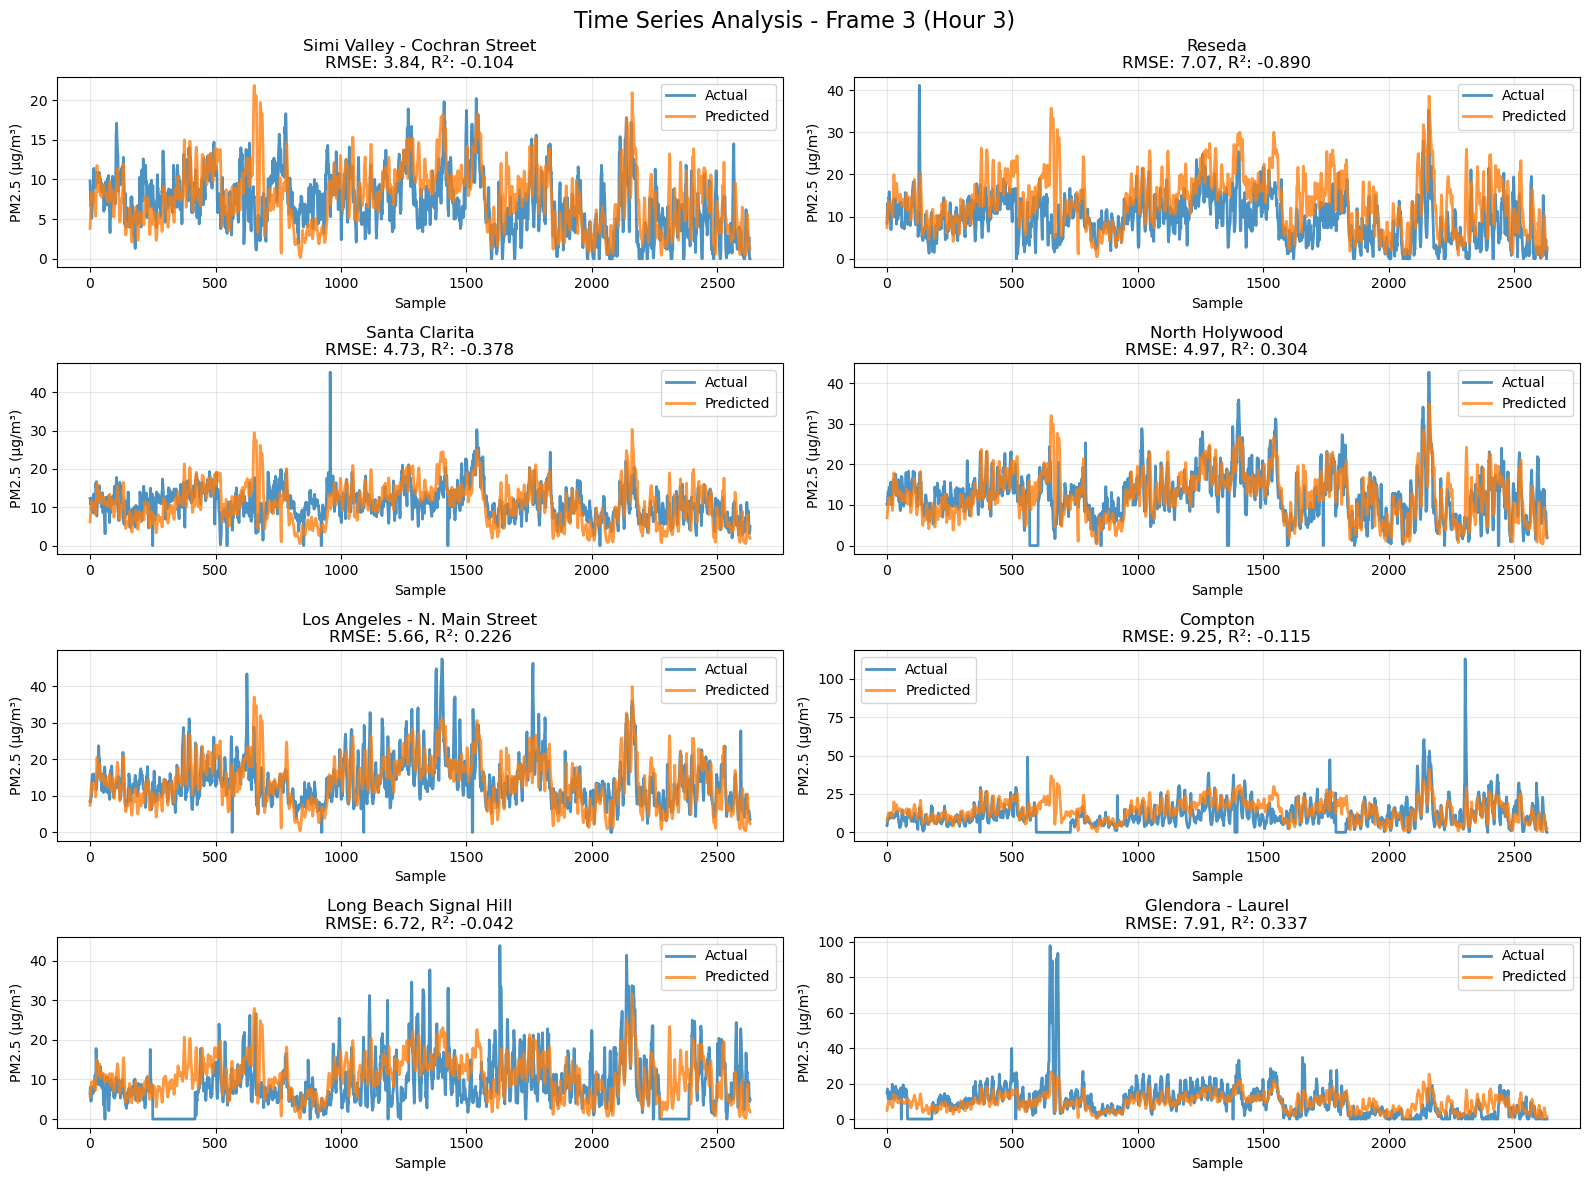


🕐 Hour 4 Time Series


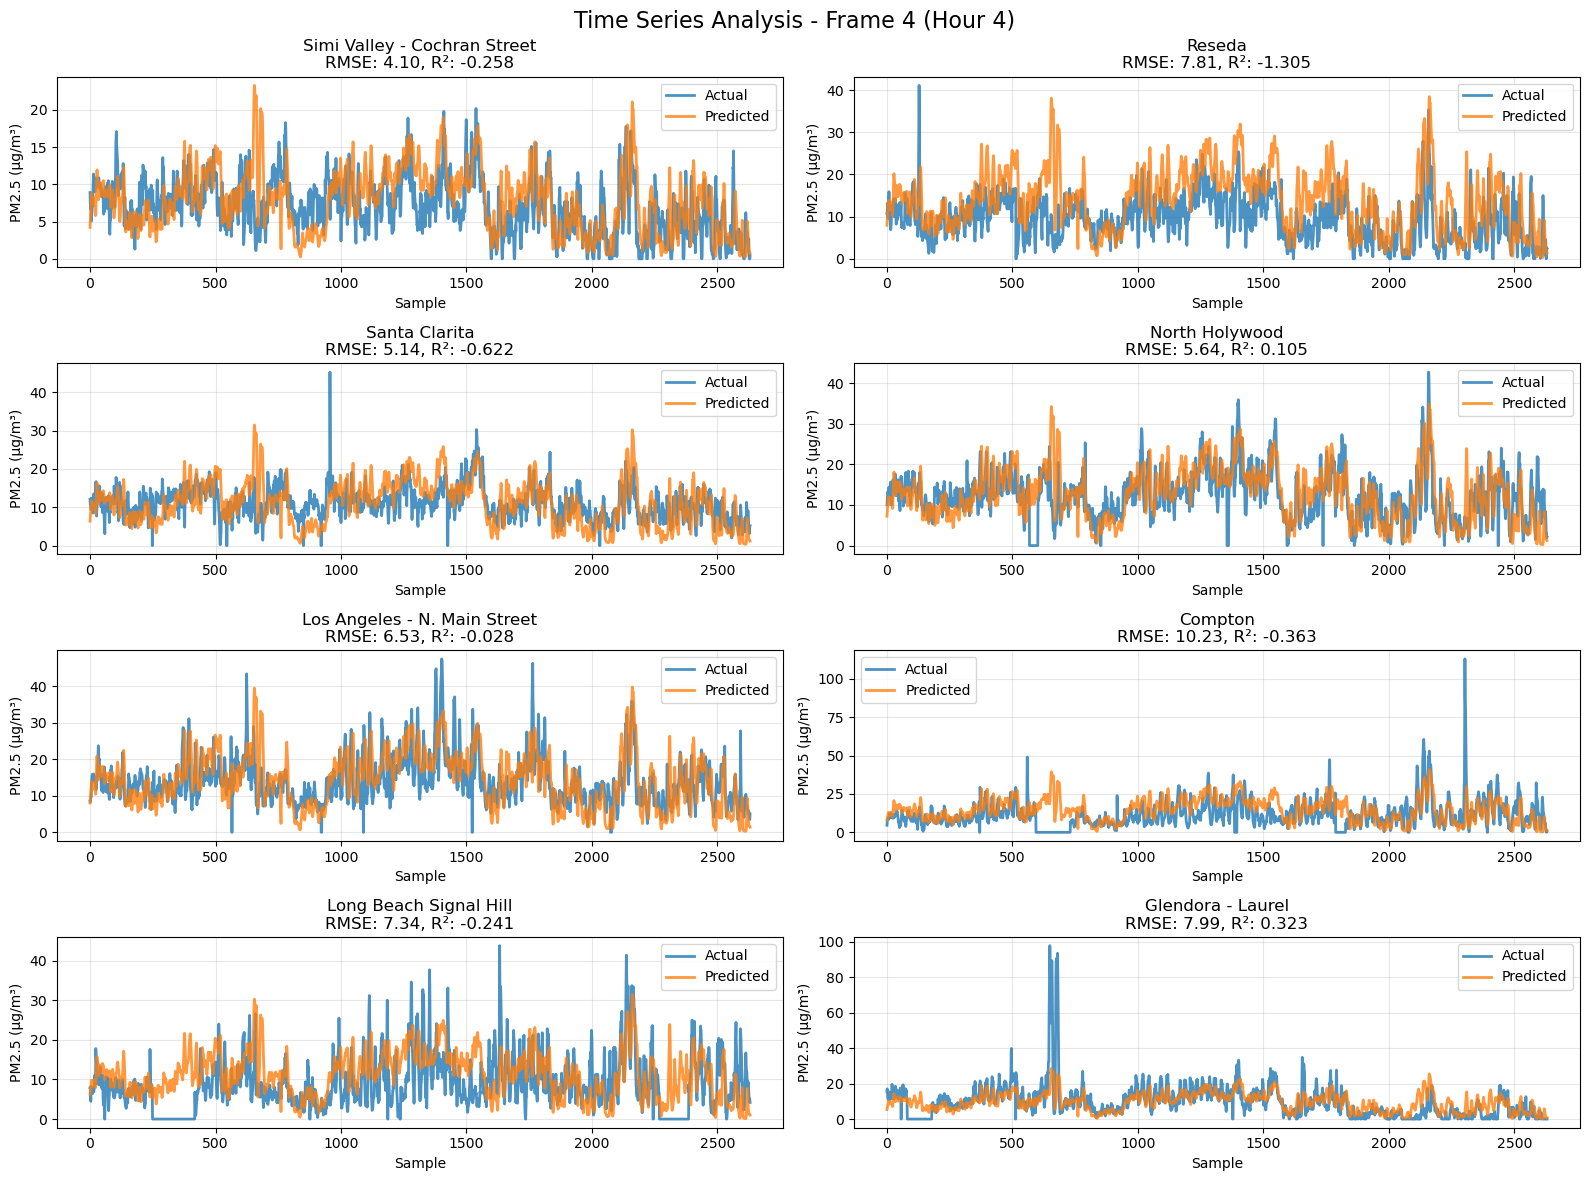


🕐 Hour 5 Time Series


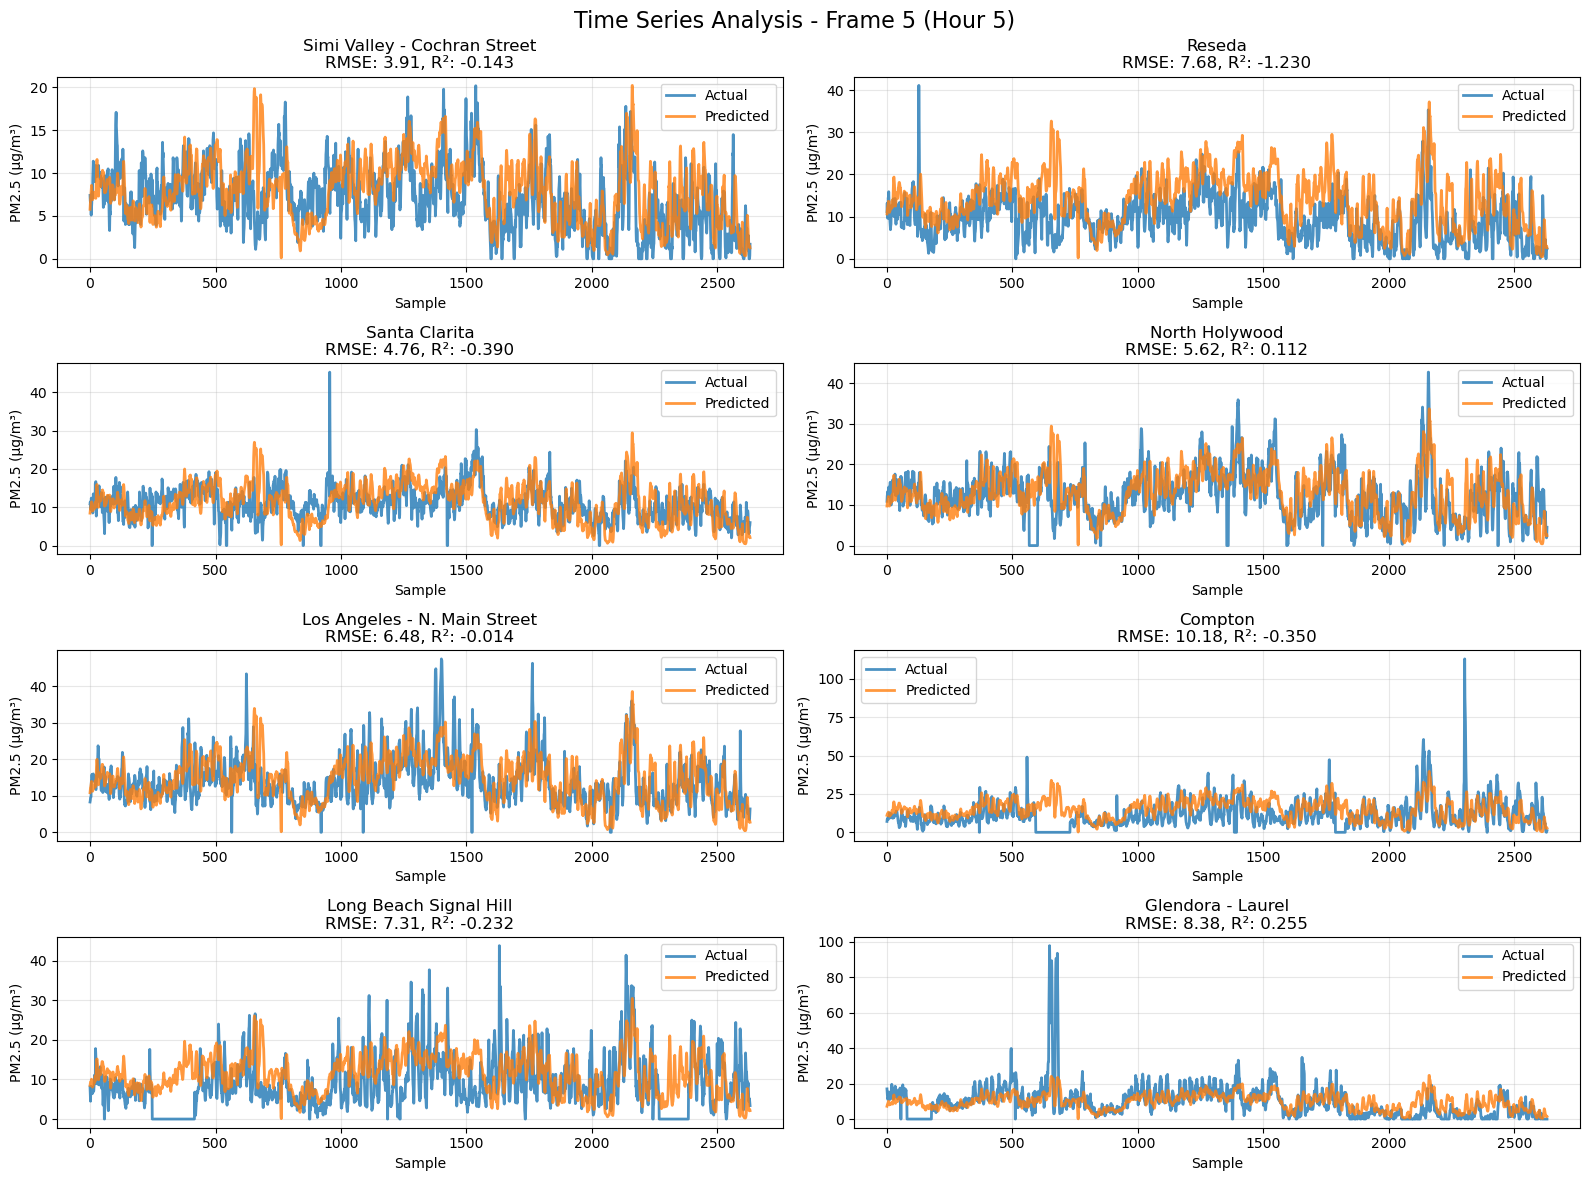


🎯 5. SCATTER PLOTS BY FRAME
───────────────────────────────────
Prediction accuracy assessment for each time frame:

🎯 Hour 1 Scatter Plot


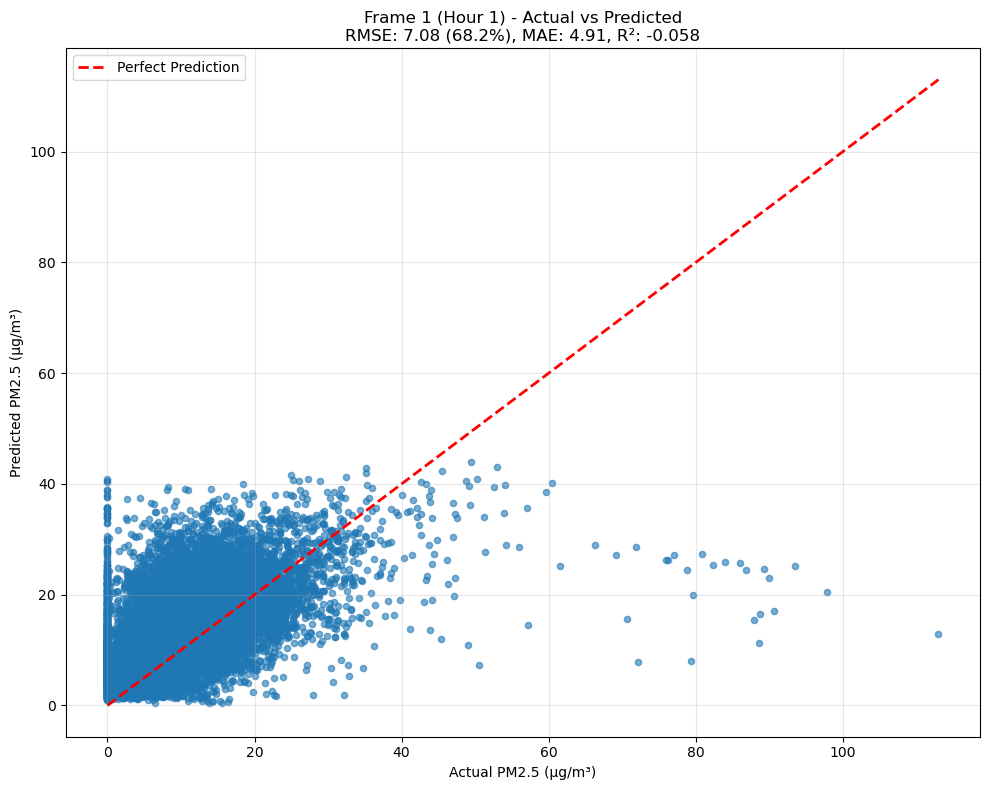


🎯 Hour 2 Scatter Plot


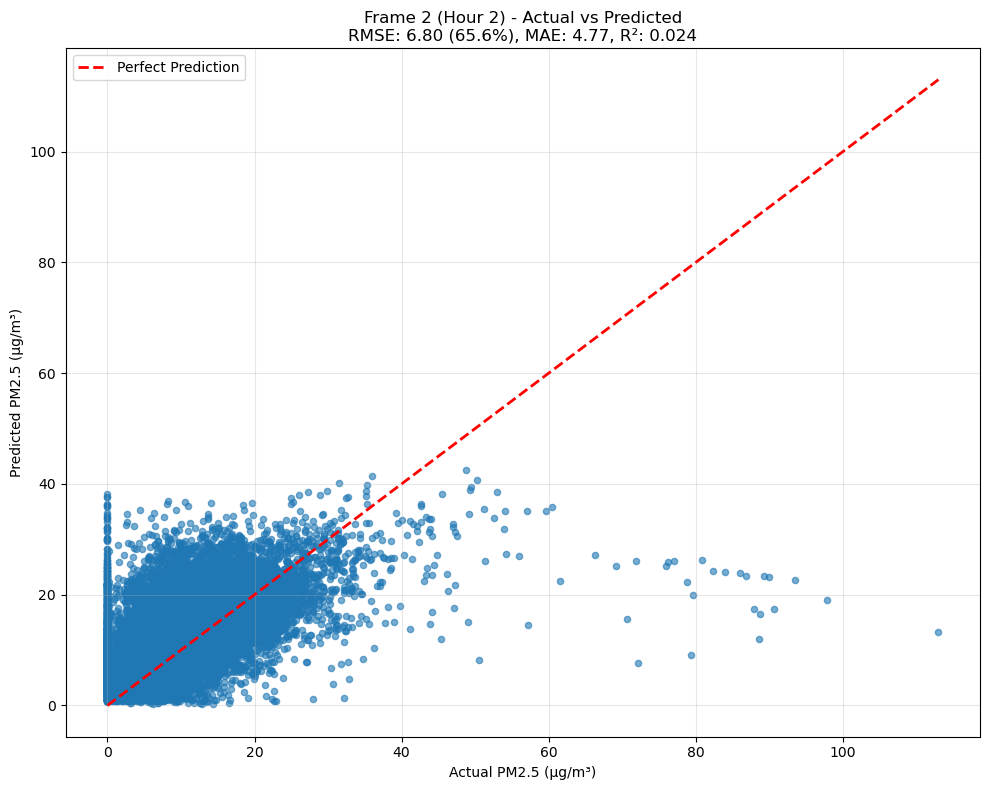


🎯 Hour 3 Scatter Plot


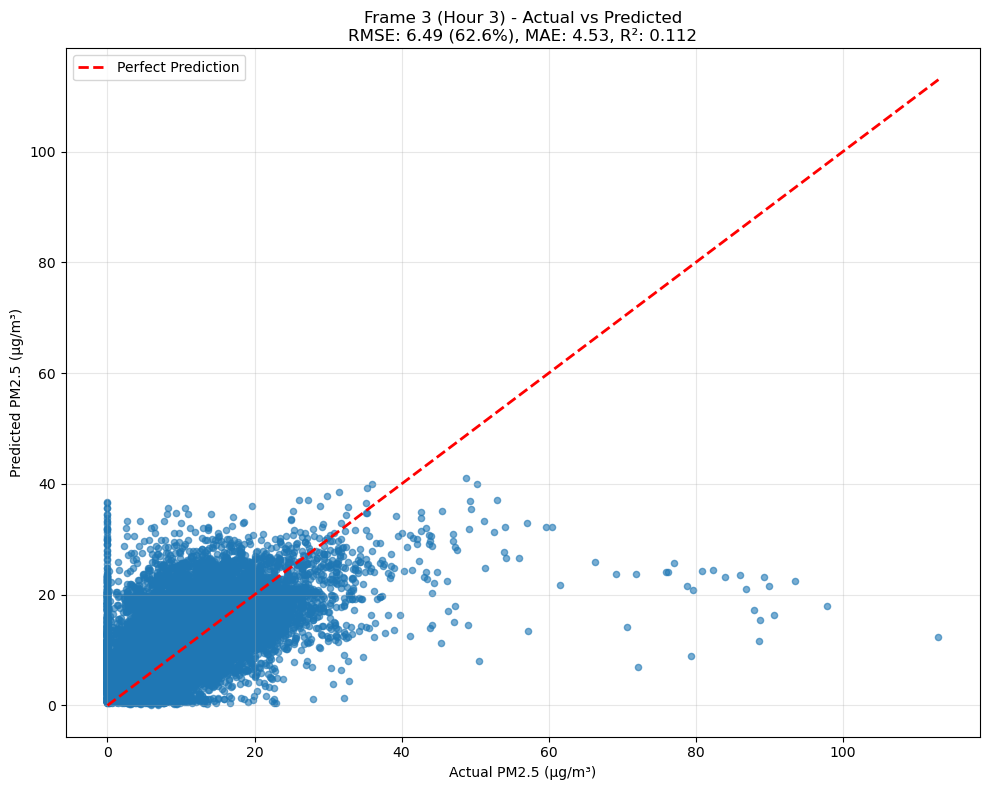


🎯 Hour 4 Scatter Plot


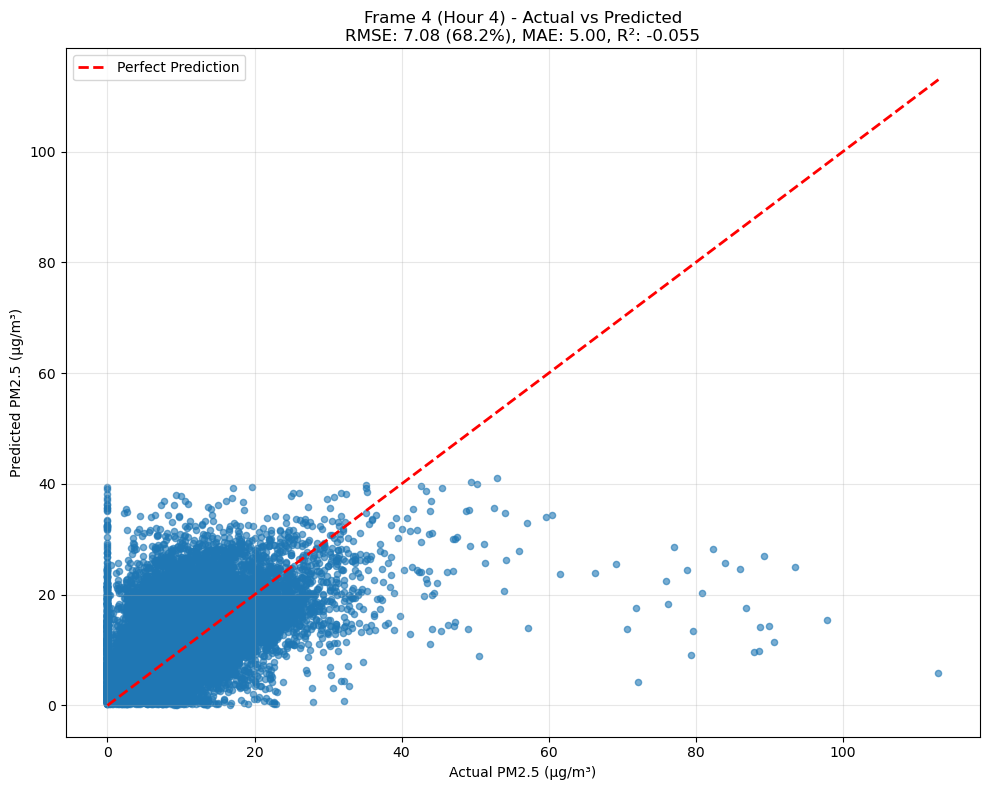


🎯 Hour 5 Scatter Plot


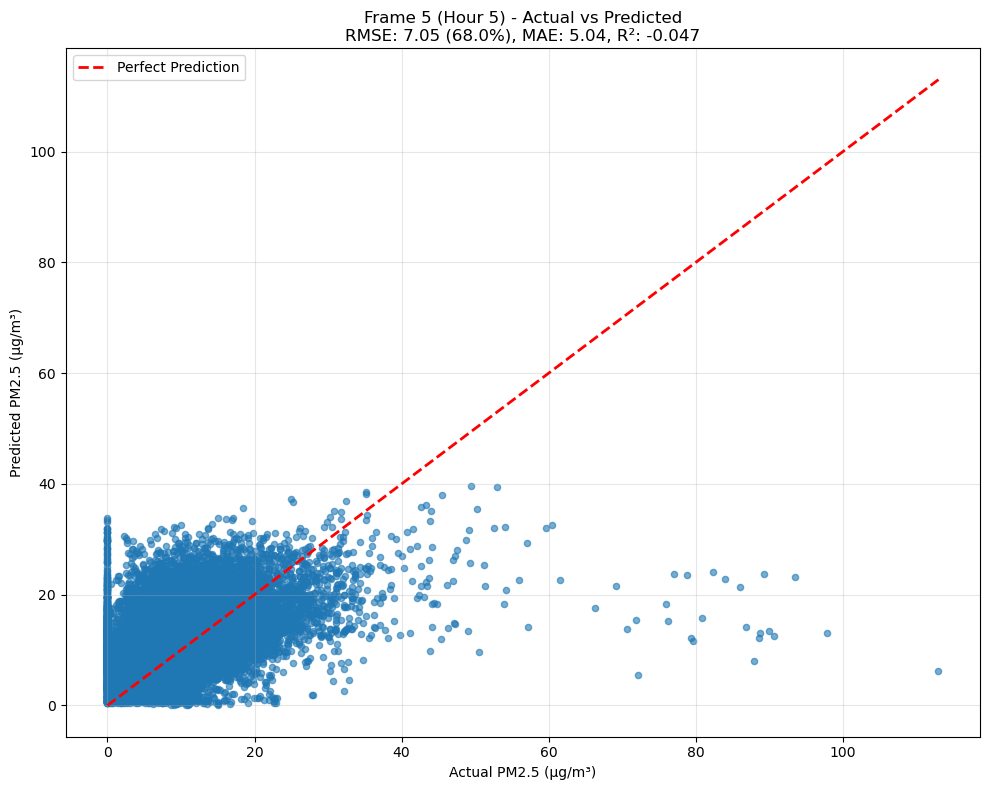

📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  7.083 (68.2%)   │   MAE:  4.910   │   R²: -0.058              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
─────────────────────────┼───────┼──────┼───────┼───────┼───────┼──────
Simi Valley - Cochran St │4.34   │62.0  %│3.26   │-0.414 │7.0    │8.4   
Reseda                   │8.50   │91.9  %│6.34

In [11]:
from libs.plotting import comprehensive_frame_analysis

# Get sensor names
sensor_names = [
    'Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 
    'Los Angeles - N. Main Street', 'Compton', 'Long Beach Signal Hill', 'Glendora - Laurel'
]

print(f"\nSensors in {EXPERIMENT_NAME}: {sensor_names}")
print(f"\n=== FRAME-BASED PREDICTION ANALYSIS ===")
print(f"Analyzing {y_pred.shape[1]} future frames (hours) for {y_pred.shape[2]} sensors") 
comprehensive_frame_analysis(y_pred, Y_test, sensor_names)

# Smoothed Analysis
Ignores sensors that were offline; default assumes perfect prediction for dead sensors.

Total number of stations: 105240
Number of stations that reported exactly 0 PM2.5, replaced with y_pred: 5005
Percent of stations replaced: 4.76%
🎯 COMPREHENSIVE CONVLSTM PERFORMANCE ANALYSIS
📊 Analyzing 5 frames (hours) across 8 sensors
📈 Dataset: 2631 samples

This analysis evaluates ConvLSTM's ability to predict air quality across multiple future time frames
and spatial locations, revealing critical spatio-temporal prediction patterns.

📊 1. FRAME-BY-FRAME RMSE
────────────────────────────────────────────────────────────
📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



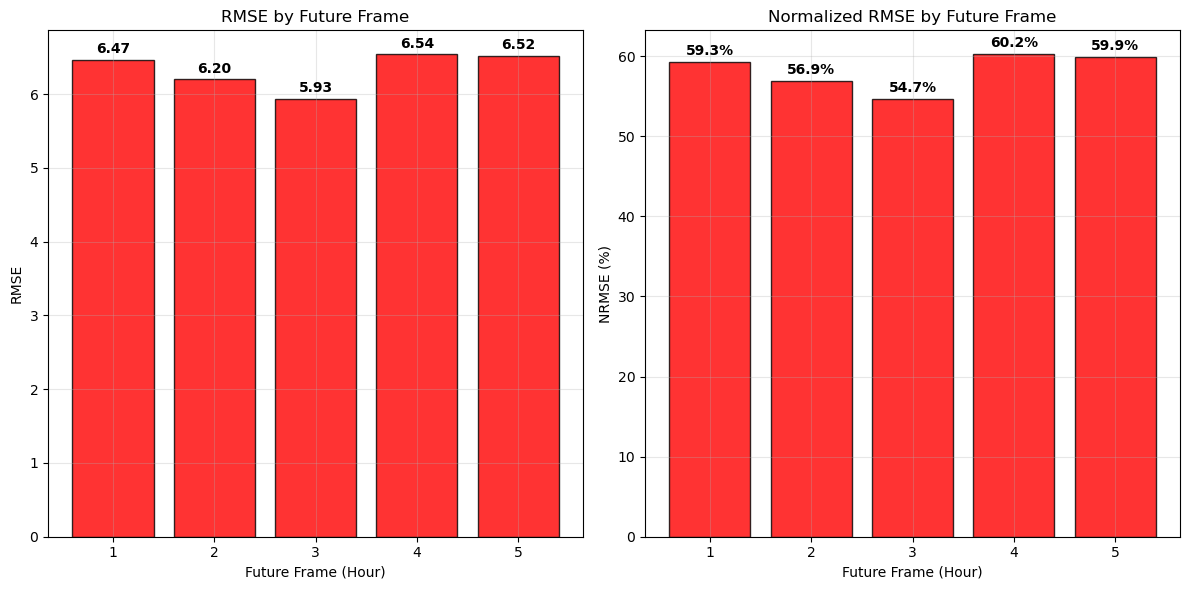


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 6.465 (59.3%)
Hour 2: RMSE = 6.198 (56.9%)
Hour 3: RMSE = 5.934 (54.7%)
Hour 4: RMSE = 6.537 (60.2%)
Hour 5: RMSE = 6.517 (59.9%)

📍 2. AVERAGE RMSE PER STATION (ALL HOURS)
───────────────────────────────────────────────────────
📍 SPATIAL PERFORMANCE ANALYSIS
This identifies which monitoring stations are consistently difficult for ConvLSTM to predict.
Challenging stations often have complex local meteorology or unique pollution sources.



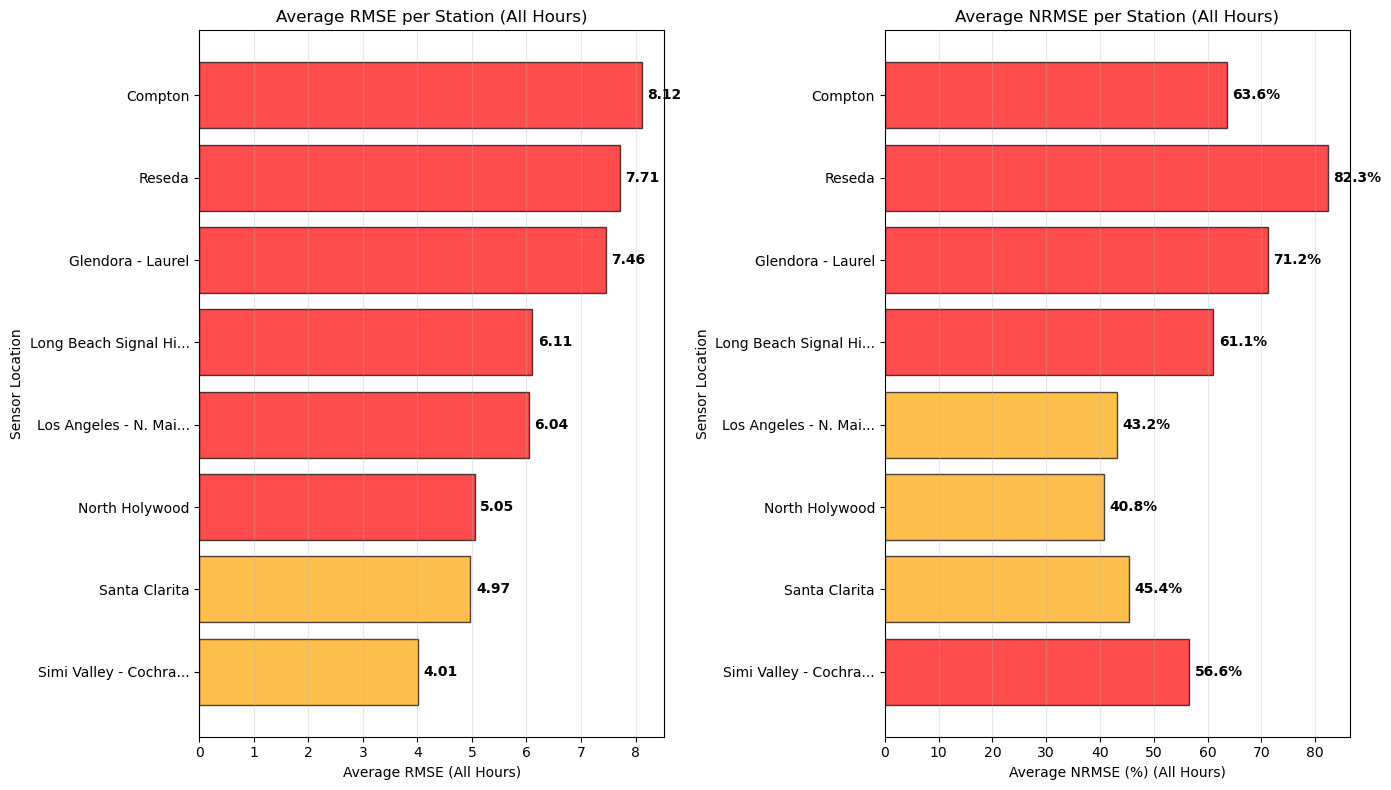


📍 STATION PERFORMANCE SUMMARY (All Hours Combined)

🟢 EXCELLENT Stations (RMSE < 1.5): 0

🟡 GOOD Stations (1.5-3.0): 0

🟠 FAIR Stations (3.0-5.0): 2
   • Simi Valley - Cochran Street: 4.009
   • Santa Clarita: 4.972

🔴 POOR Stations (≥ 5.0): 6
   • North Holywood: 5.049
   • Los Angeles - N. Main Street: 6.038
   • Long Beach Signal Hill: 6.106
   • Glendora - Laurel: 7.459
   • Reseda: 7.711
   • Compton: 8.118

📊 SUMMARY STATISTICS:
   🏆 Best Station:  Simi Valley - Cochran Street (RMSE: 4.009)
   💥 Worst Station: Compton (RMSE: 8.118)
   📈 Average RMSE:  6.183
   📏 RMSE Range:    4.108
   🎯 Reliability:   0/8 stations ≤ 3.0 RMSE

📊 SUMMARY TABLE - RMSE BY HOUR AND SENSOR
Sensor                   │ Hour 1 │ Hour 2 │ Hour 3 │ Hour 4 │ Hour 5 │  Avg   
─────────────────────────┼────────┼────────┼────────┼────────┼────────┼────────
Simi Valley - Cochran St │  4.28  │  4.04  │  3.79  │  4.06  │  3.85  │  4.01  
Reseda                   │  8.40  │  7.82  │  6.98  │  7.72  │  7.57  │  7.7

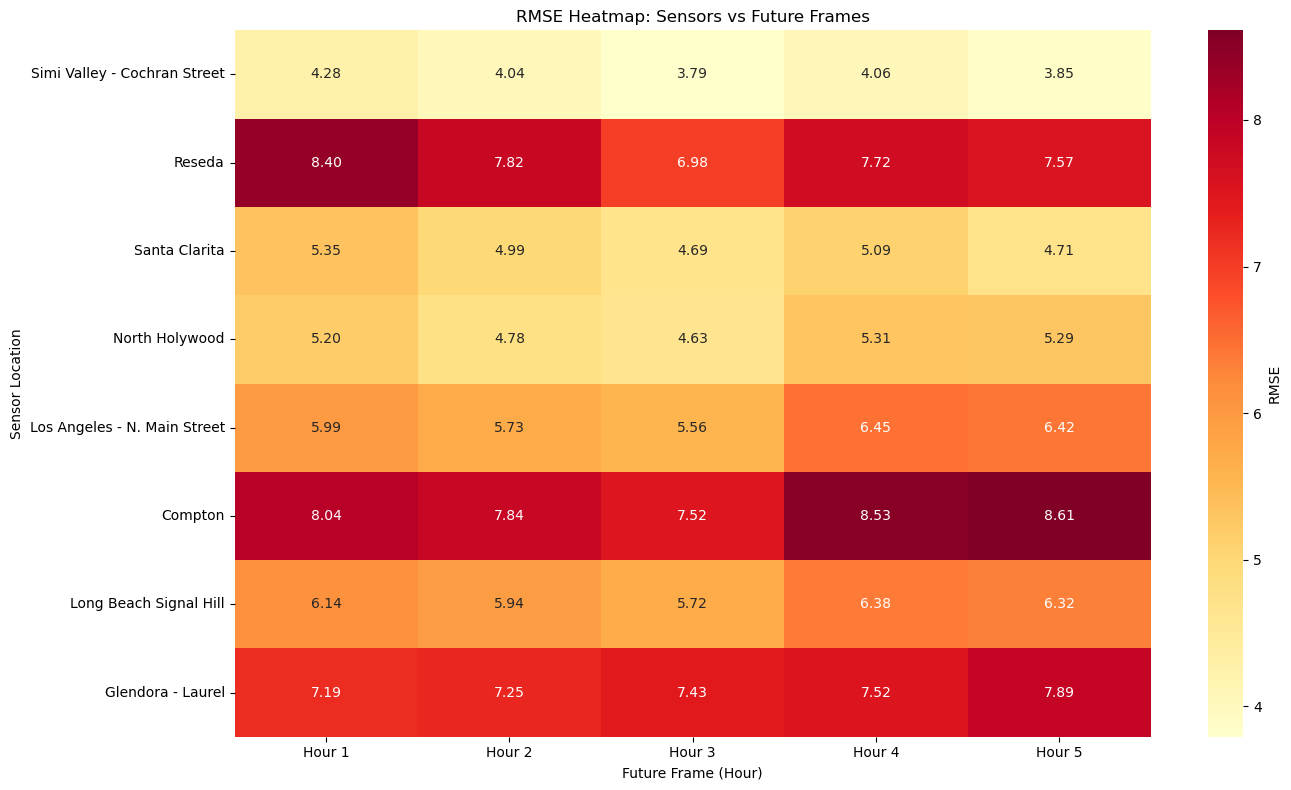


🔥 WORST PERFORMING COMBINATIONS:
Compton at Hour 5: RMSE = 8.611
Compton at Hour 4: RMSE = 8.531
Reseda at Hour 1: RMSE = 8.404
Compton at Hour 1: RMSE = 8.036
Glendora - Laurel at Hour 5: RMSE = 7.891

📈 4. TIME SERIES BY FRAME
───────────────────────────────────
Temporal pattern analysis

🕐 Hour 1 Time Series


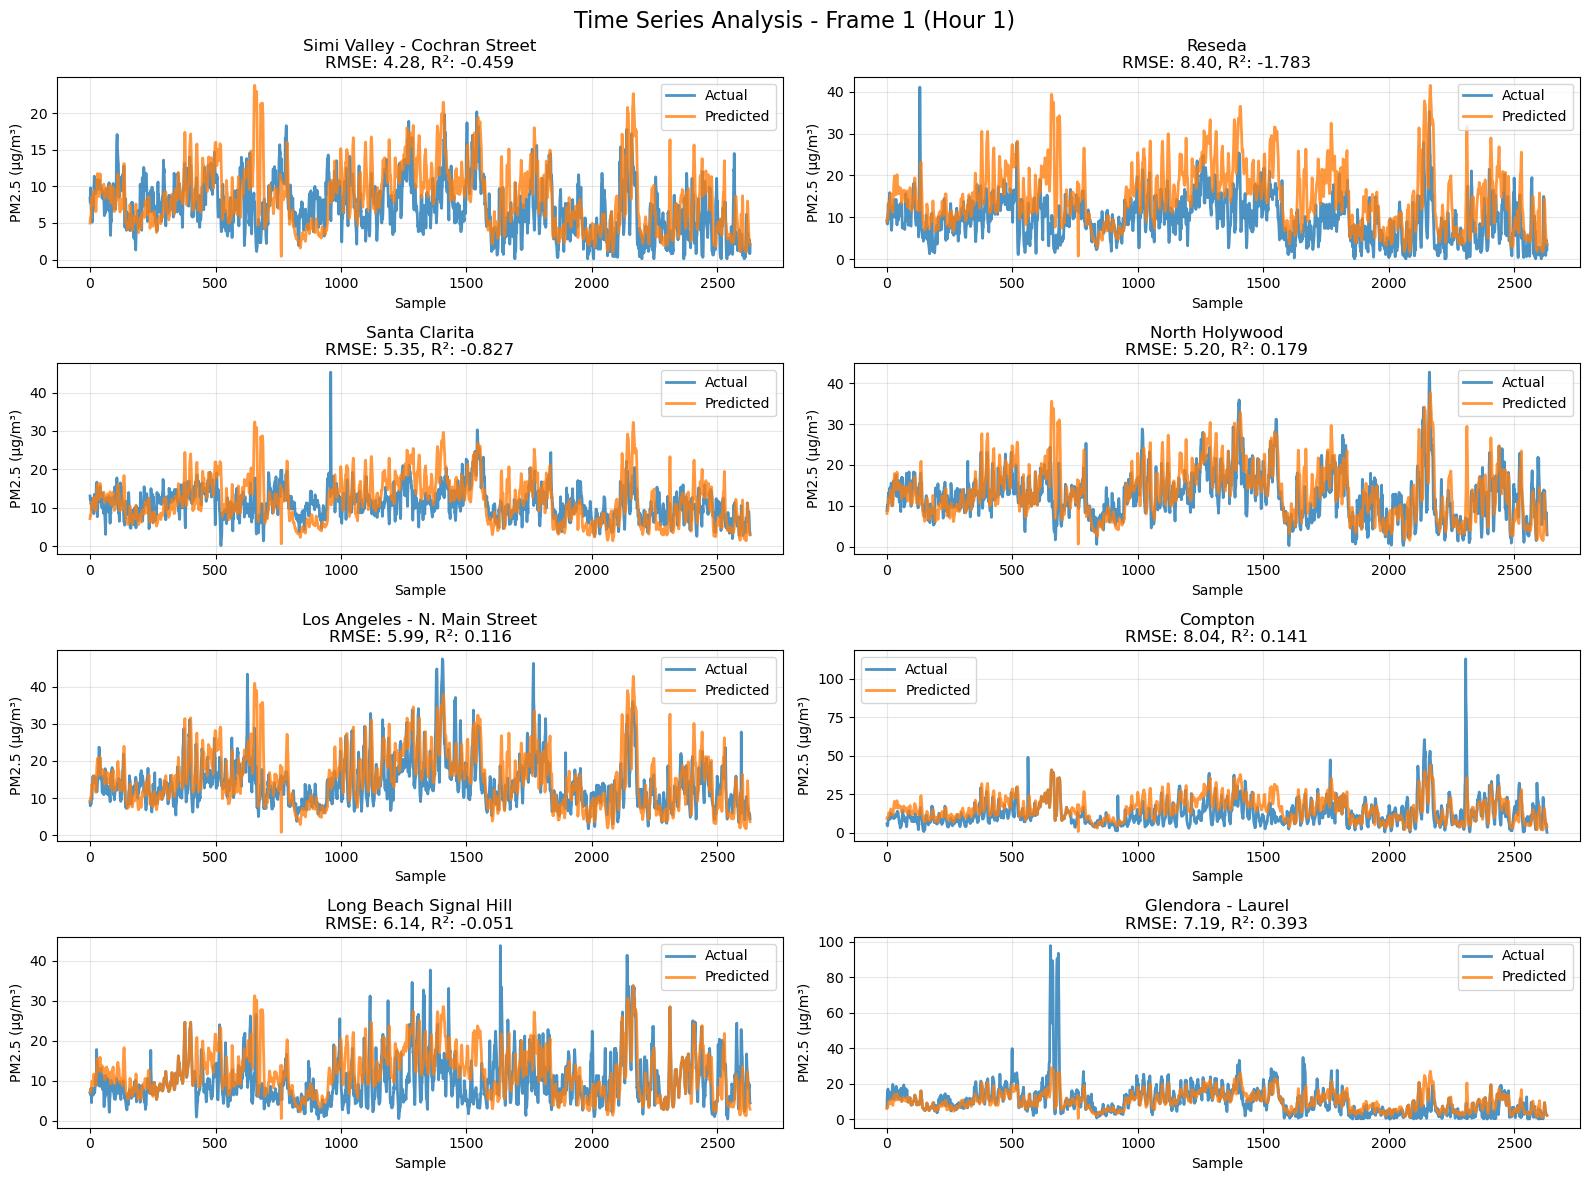


🕐 Hour 2 Time Series


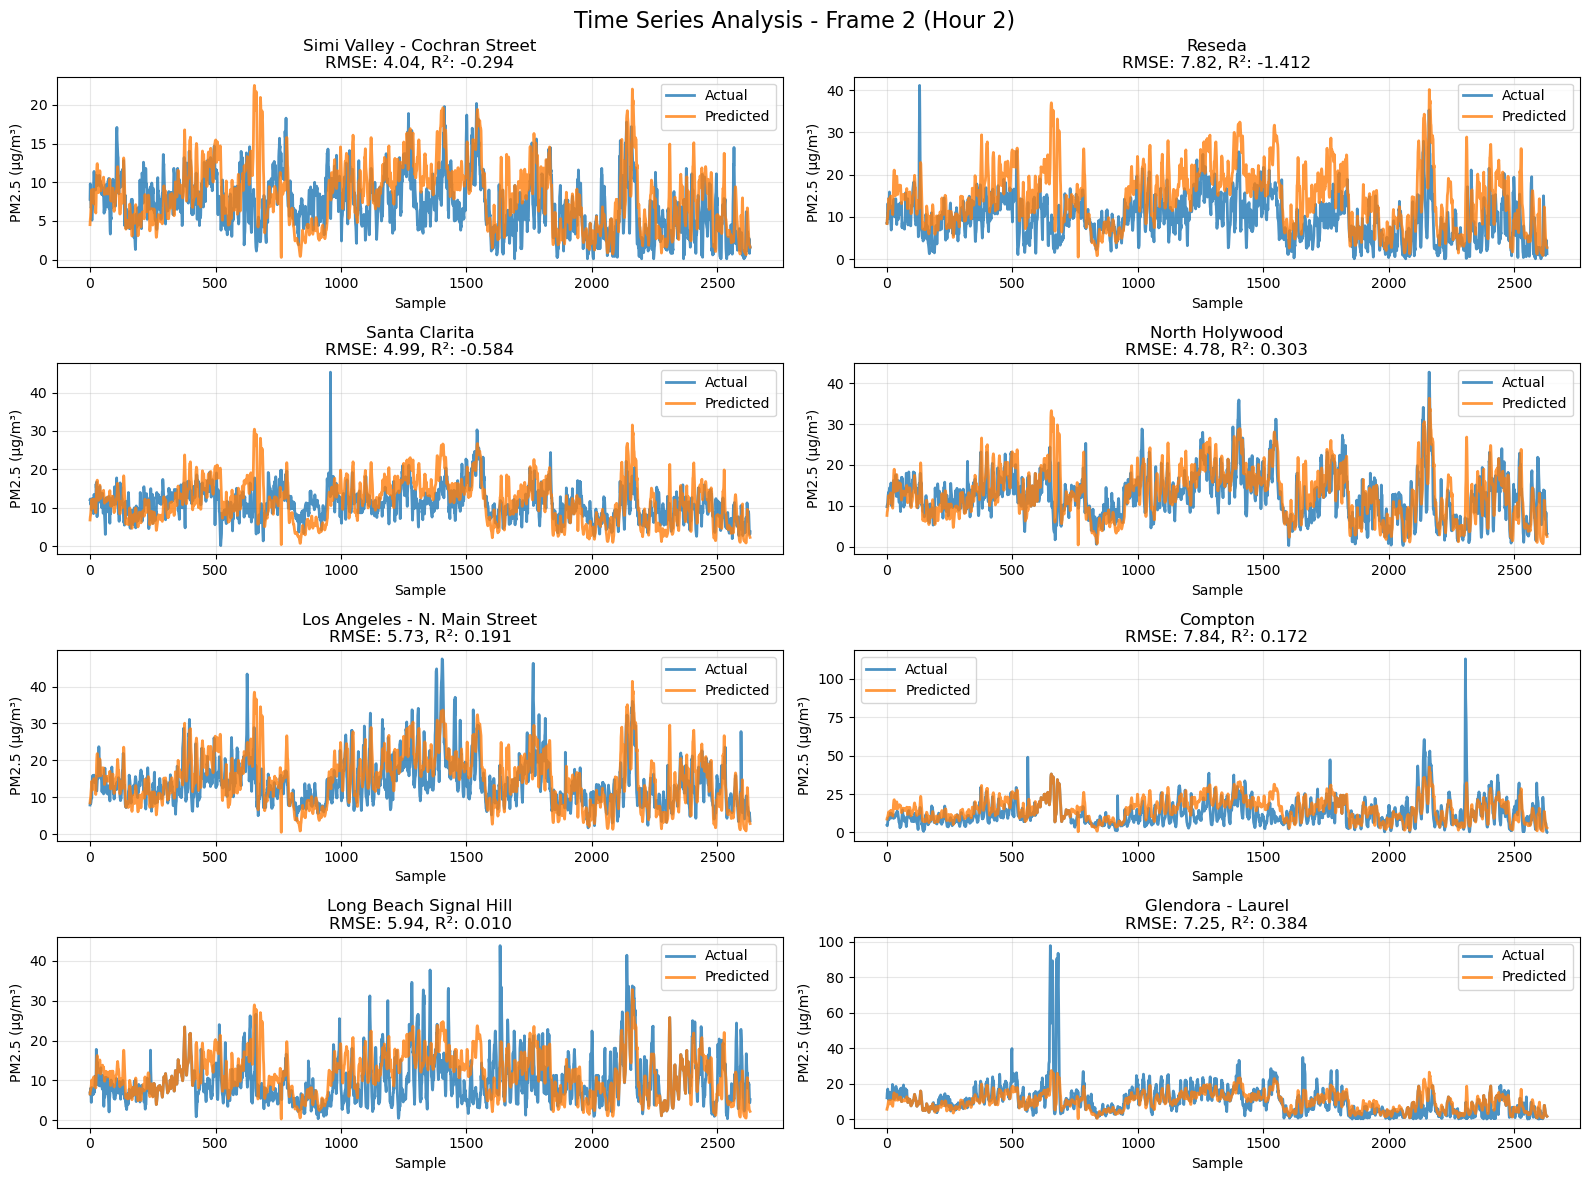


🕐 Hour 3 Time Series


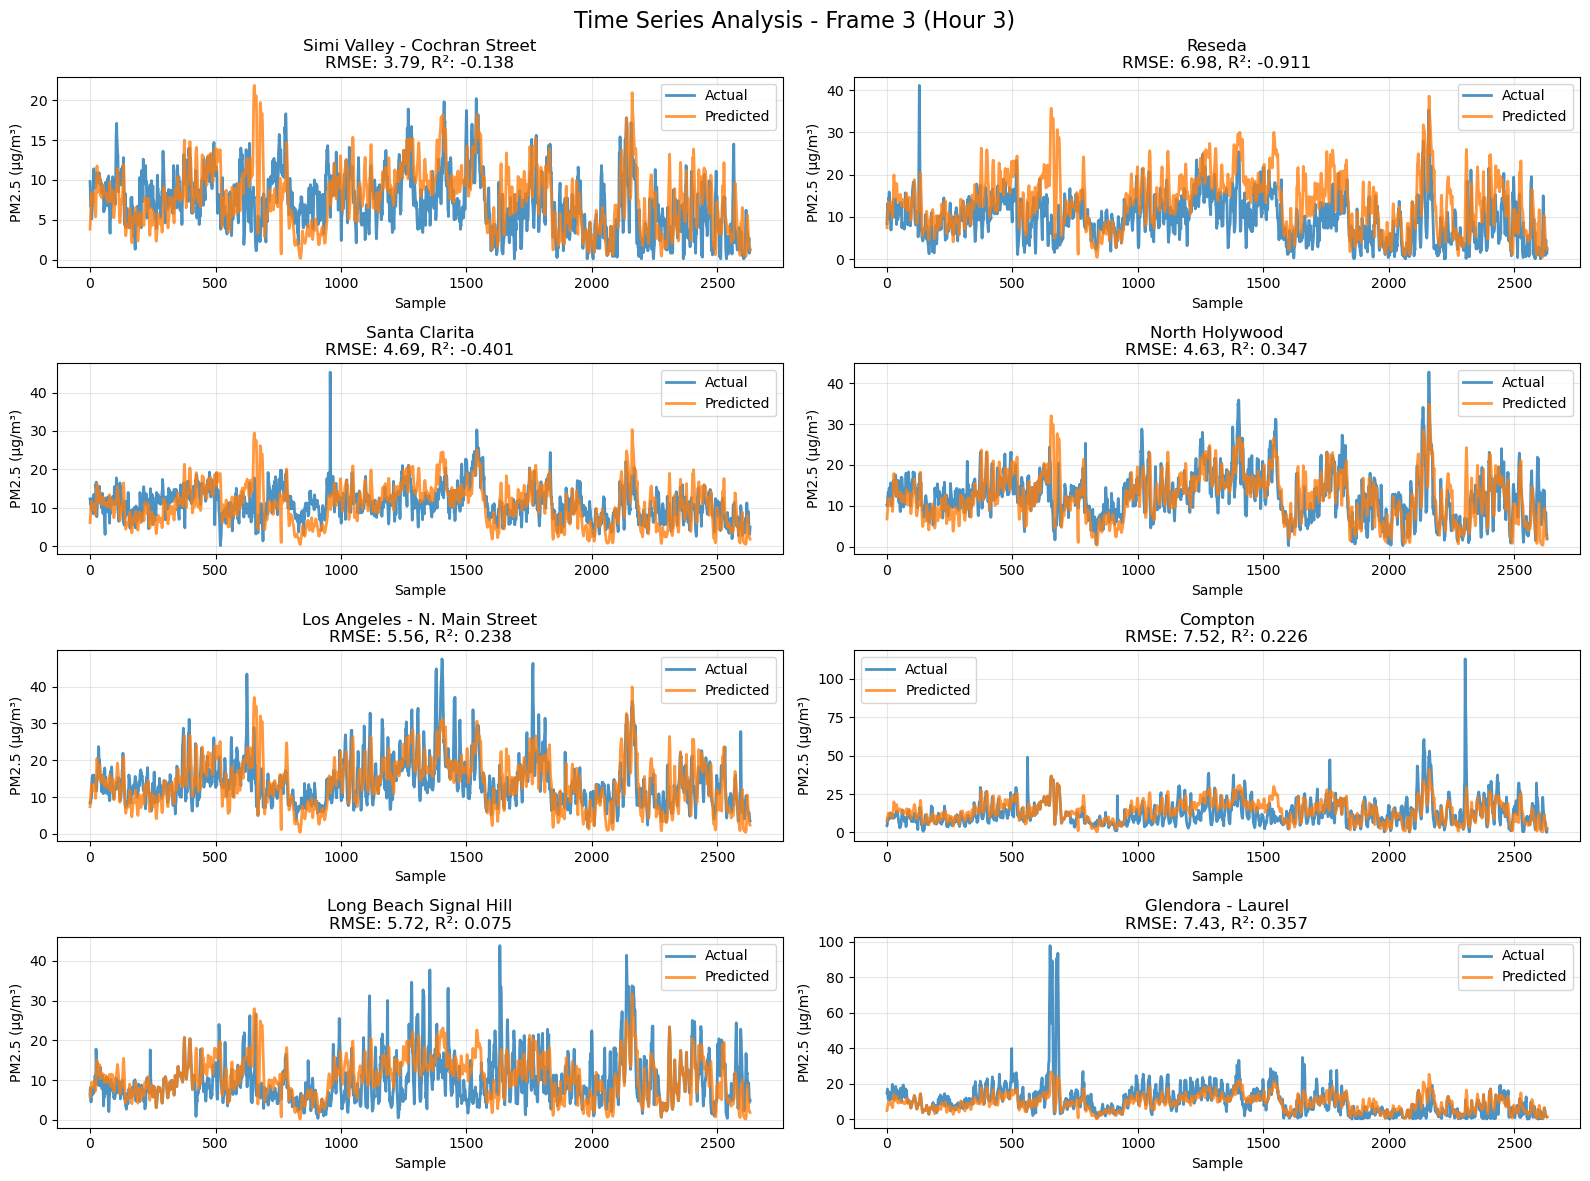


🕐 Hour 4 Time Series


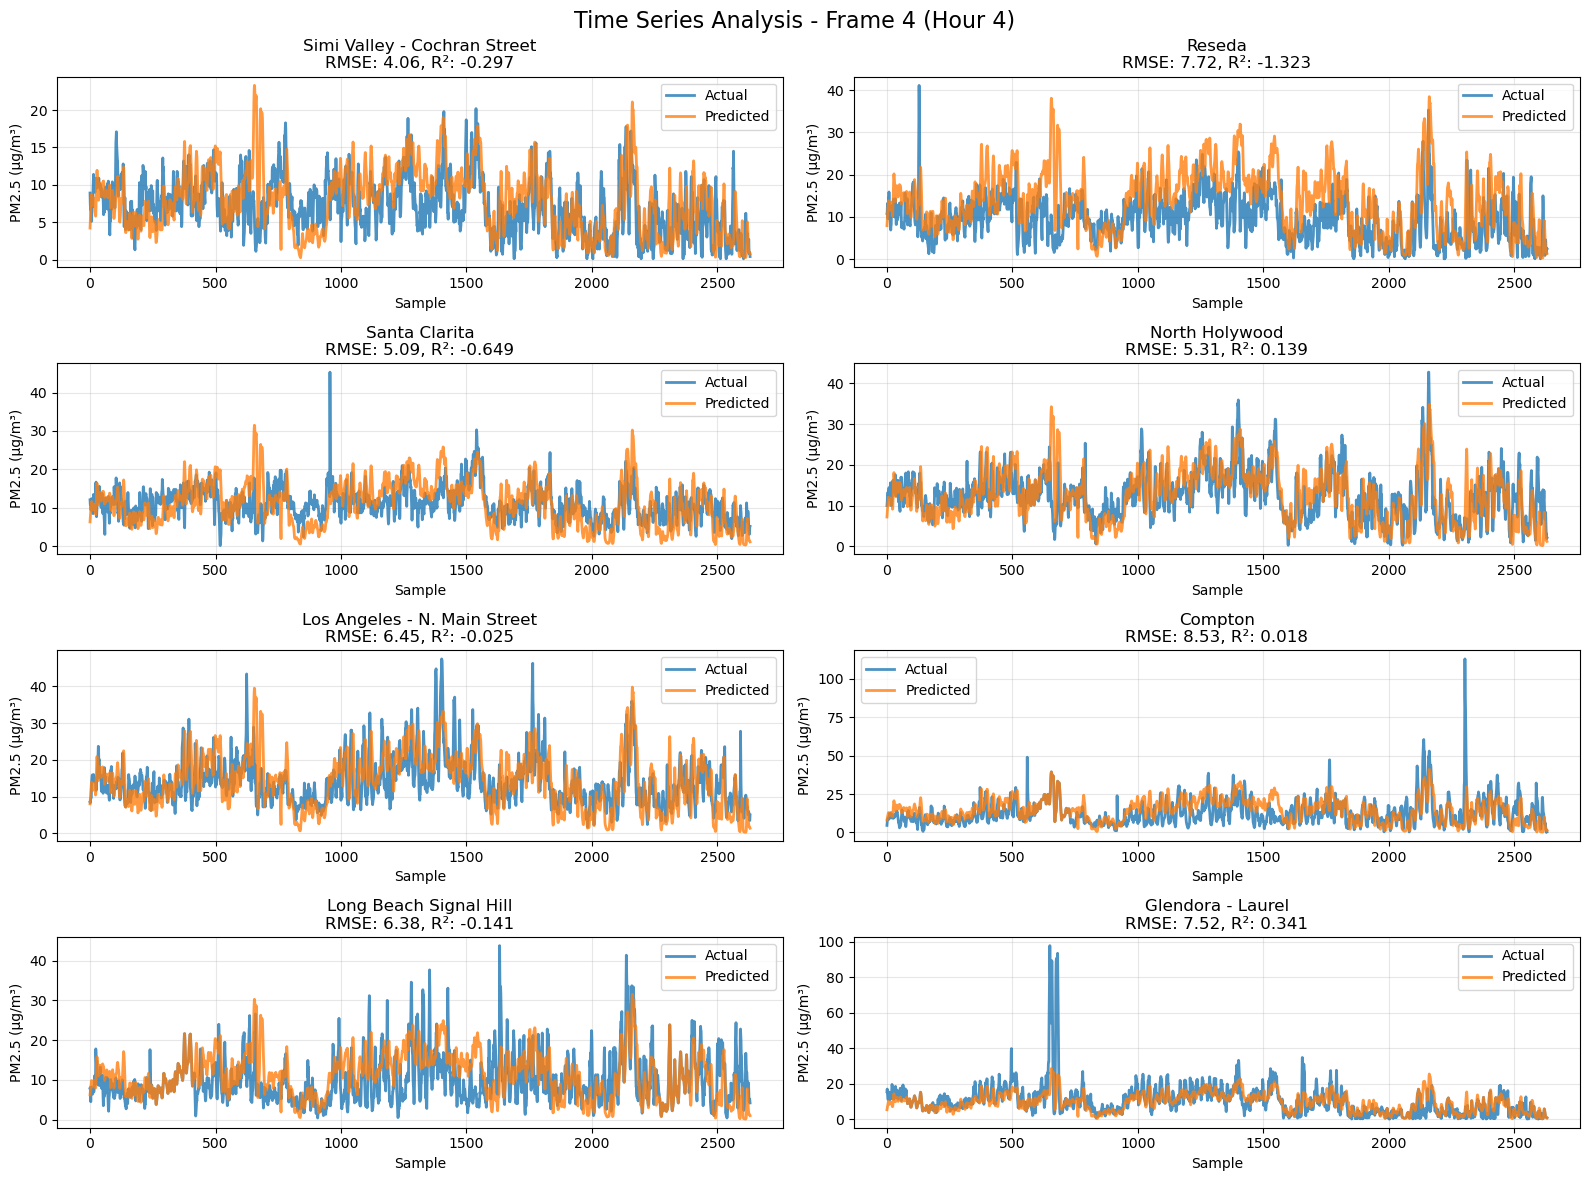


🕐 Hour 5 Time Series


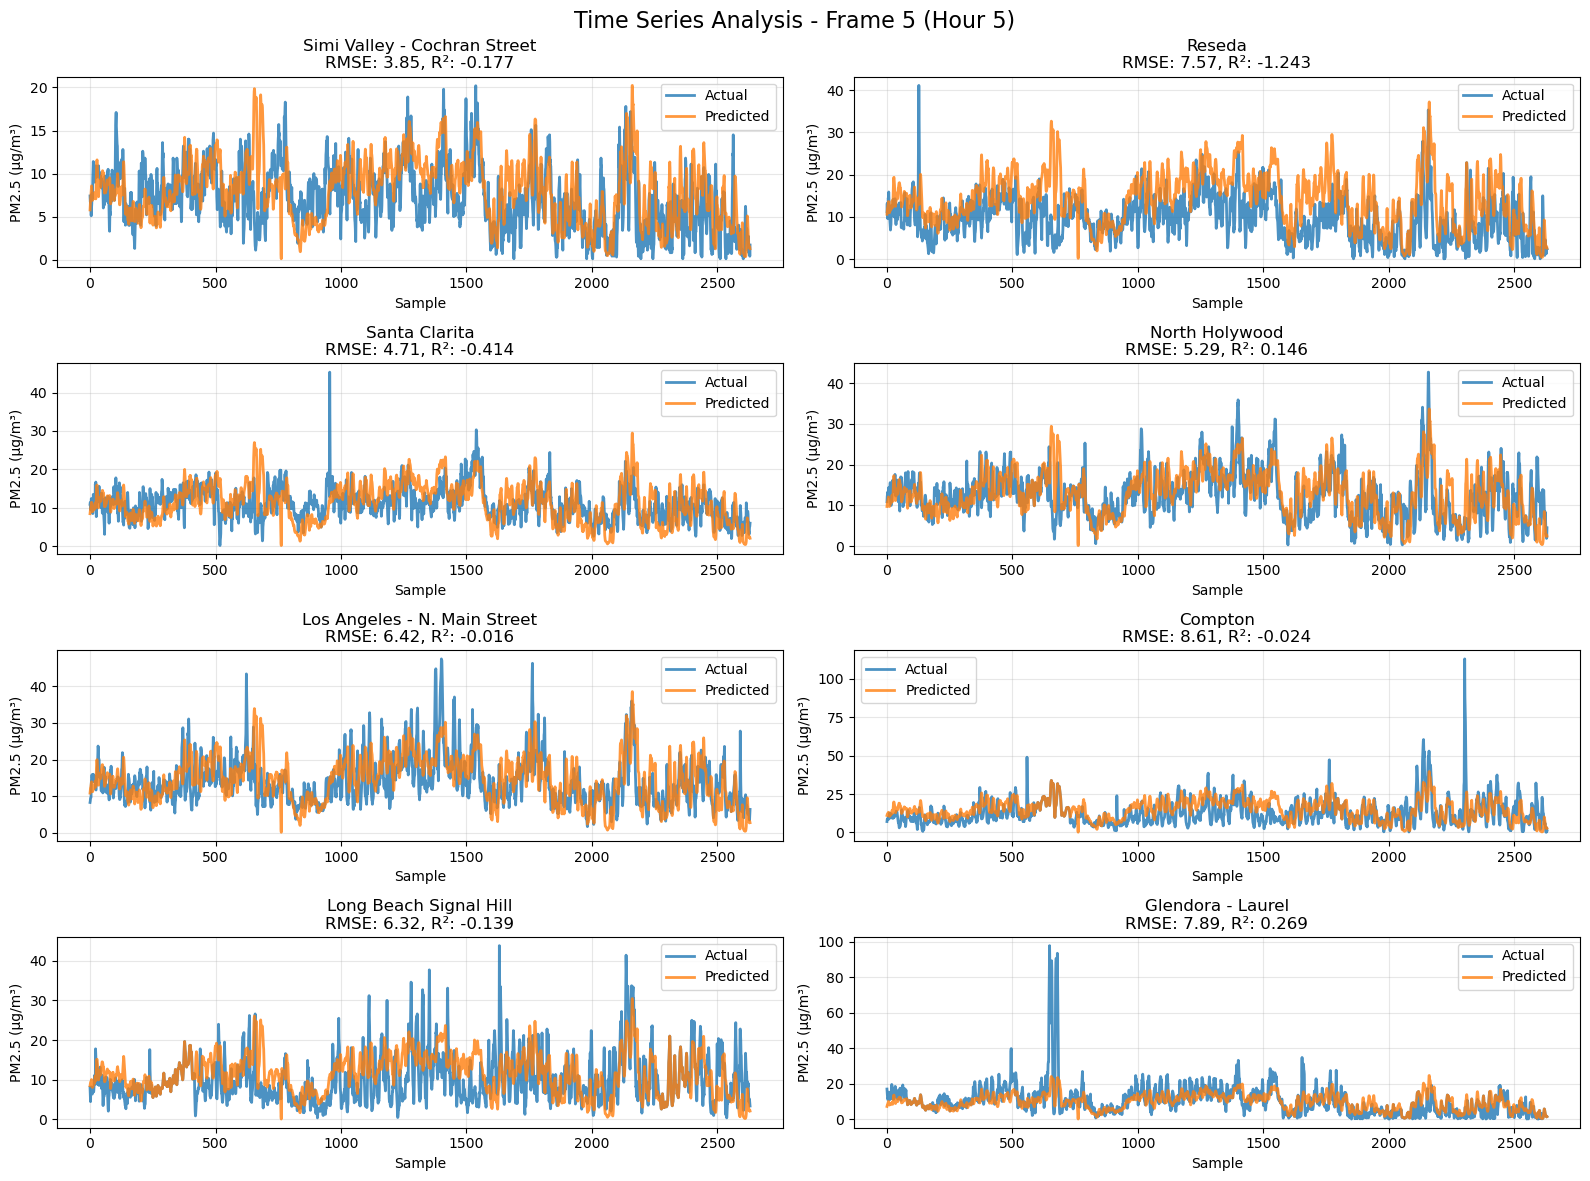


🎯 5. SCATTER PLOTS BY FRAME
───────────────────────────────────
Prediction accuracy assessment for each time frame:

🎯 Hour 1 Scatter Plot


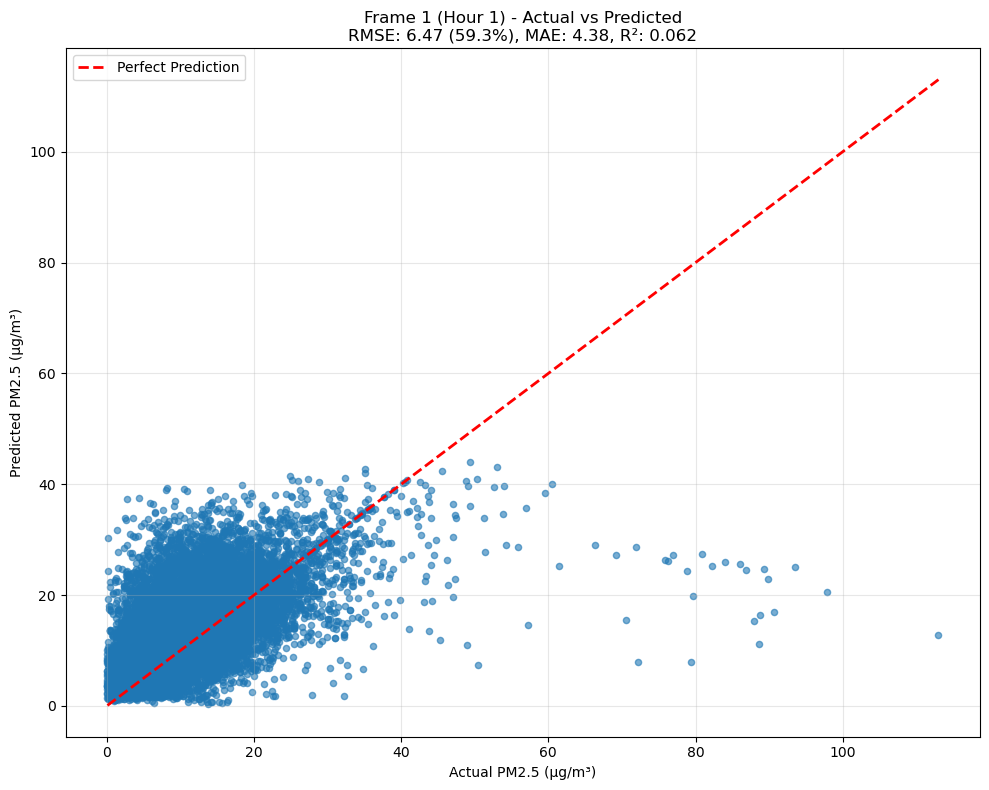


🎯 Hour 2 Scatter Plot


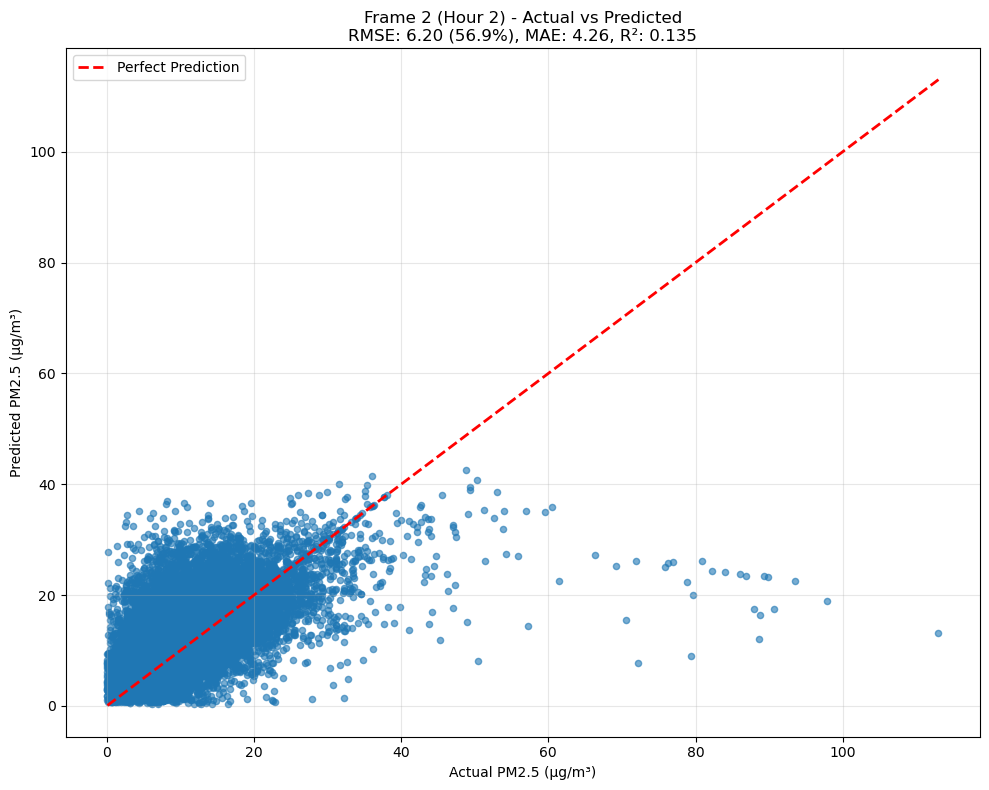


🎯 Hour 3 Scatter Plot


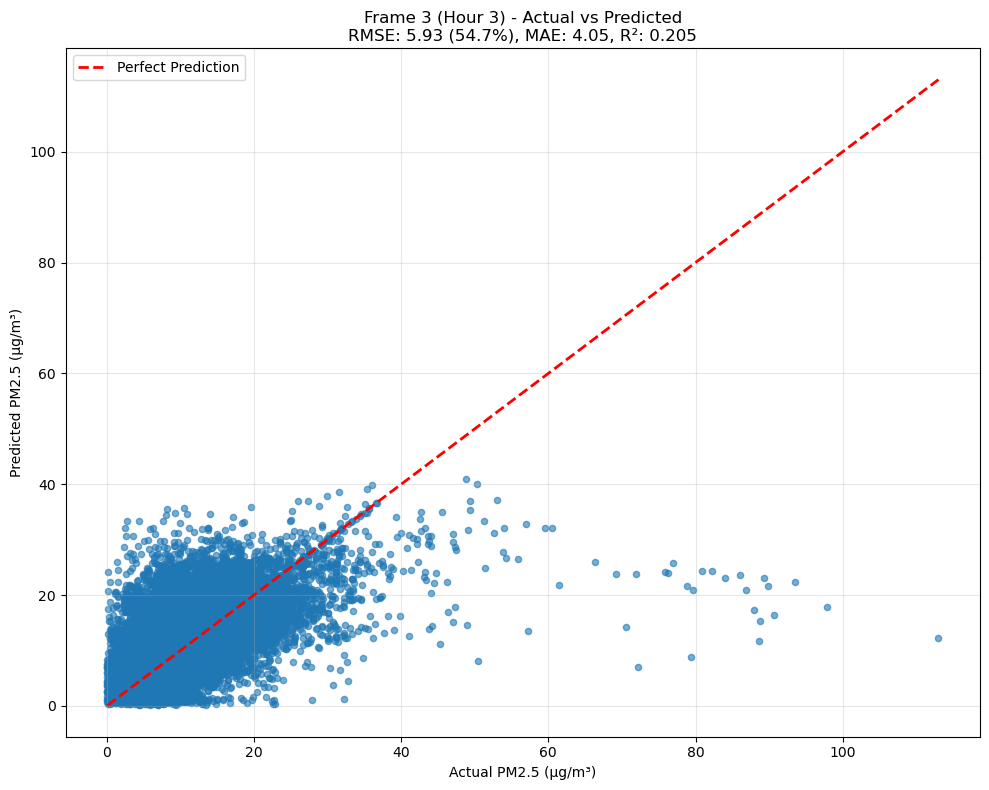


🎯 Hour 4 Scatter Plot


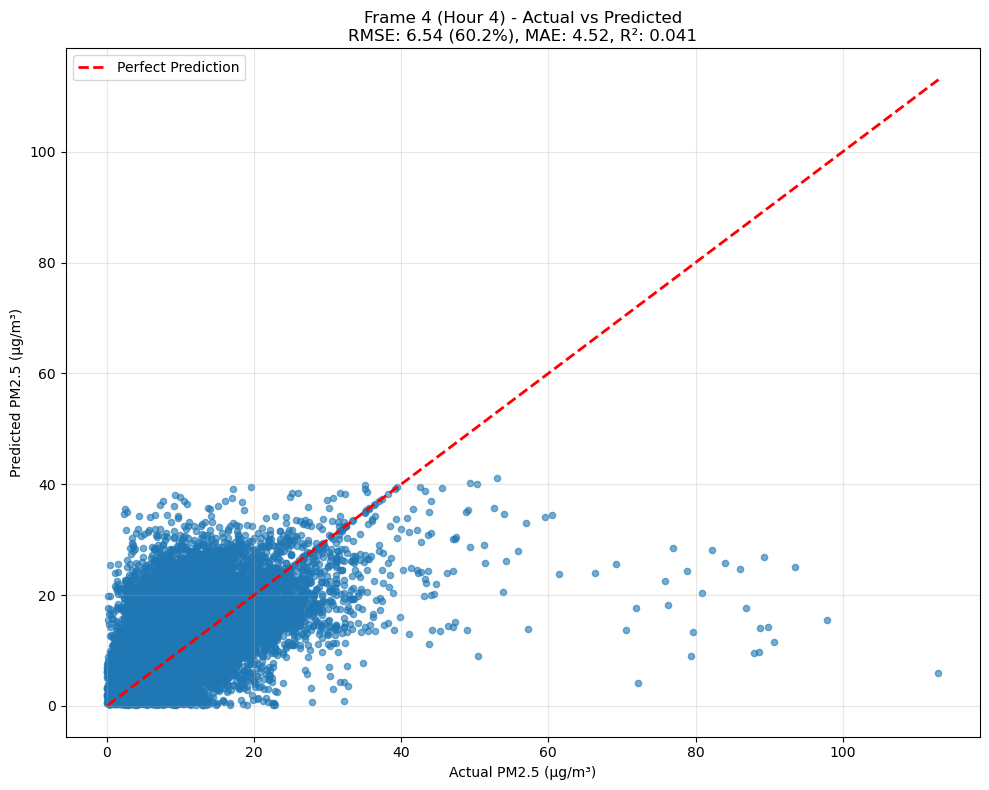


🎯 Hour 5 Scatter Plot


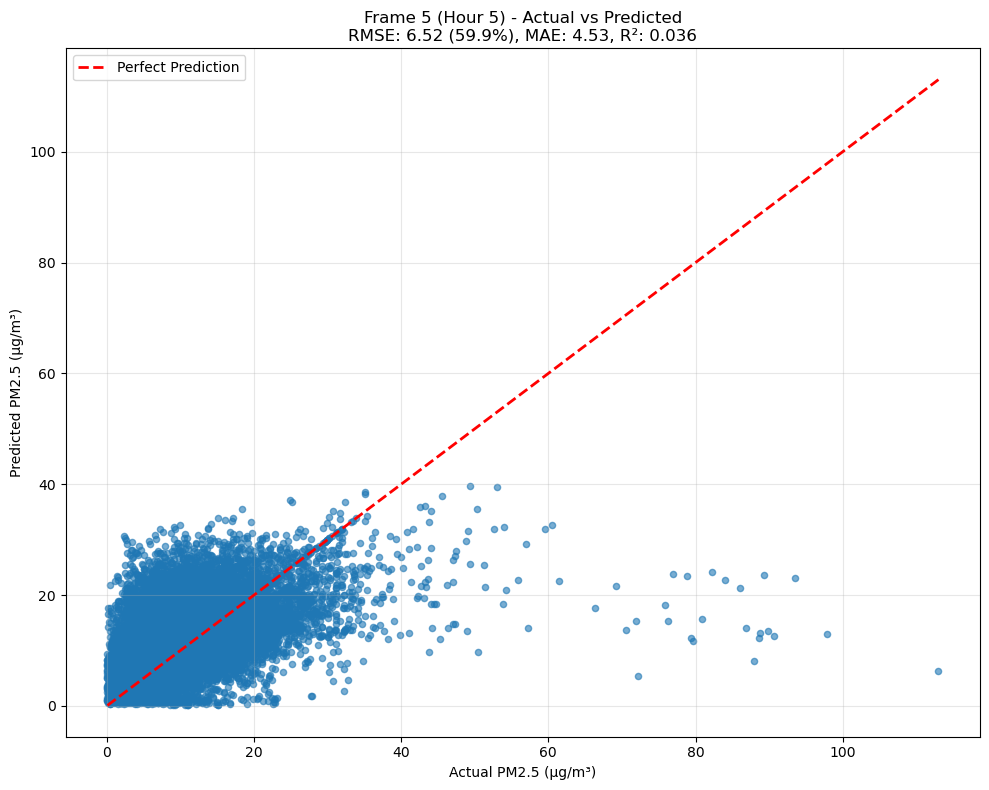

📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  6.465 (59.3%)   │   MAE:  4.382   │   R²:  0.062              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
─────────────────────────┼───────┼──────┼───────┼───────┼───────┼──────
Simi Valley - Cochran St │4.28   │60.3  %│3.17   │-0.459 │7.1    │8.4   
Reseda                   │8.40   │89.5  %│6.20

In [28]:
import math

Y_test_smoothed = Y_test.copy()
broken_idx = np.transpose(np.where(Y_test == 0))
for sample, frame, station in broken_idx:
    Y_test_smoothed[sample, frame, station] = y_pred[sample, frame, station]

total_stations = math.prod(y_pred.shape)
print(
    f"Total number of stations: {total_stations}\n"
    f"Number of stations that reported exactly 0 PM2.5, replaced with y_pred: {len(broken_idx)}\n"
    f"Percent of stations replaced: {len(broken_idx)/total_stations*100:.2f}%"
)
              
comprehensive_frame_analysis(y_pred, Y_test_smoothed, sensor_names)